# Financial Transactions Dataset for Fraud Analytics

**Objective**
- Perform predictive modeling for fraud analytics

**Outline**:
1. Business Understanding
2. Importing Data
3. Data Preparation
4. Splitting Data
5. Data Pre-Processing
6. Modeling
7. Prediction

---

In [1]:
# import libraries
import numpy as np

import os
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# <font color = 'blue'> 1. Business Understanding
---

**Overview**

This comprehensive financial dataset combines transaction records, customer information, and card data from a banking institution, spanning across the 2010s decade. The dataset is designed for multiple analytical purposes, including synthetic fraud detection, customer behavior analysis, and expense forecasting.

## 1.1 Data Description

**Dataset Components**

<font color = 'blue'> a. Transaction Data (transactions_data.csv)
- Detailed transaction records including amounts, timestamps, and merchant details
- Covers transactions throughout the 2010s
- Features transaction types, amounts, and merchant information
- Perfect for analyzing spending patterns and building fraud detection models

<font color = 'blue'> b. Card Information (cards_dat.csv)
- Credit and debit card details
- Includes card limits, types, and activation dates
- Links to customer accounts via card_id
- Essential for understanding customer financial profiles


<font color = 'blue'> c. Merchant Category Codes (mcc_codes.json)
- Standard classification codes for business types
- Enables transaction categorization and spending analysis
- Industry-standard MCC codes with descriptions


<font color = 'blue'>d. Fraud Labels (train_fraud_labels.json)
- Binary classification labels for transactions
- Indicates fraudulent vs. legitimate transactions
- Ideal for training supervised fraud detection models


<font color = 'blue'>e. User Data (users_data.csv)
- Demographic information about customers
- Account-related details
- Enables customer segmentation and personalized analysis

## 1.2 Define the Problem

- We are facing two problems
  - If we incorrectly predict fraud transaction as not fraud, we will loss due to the fraud.
  - If we incorrectly predict not fraud transaction as fraud, we will loss the customer.

- Hence, we create a model to **classify** between fraud and not fraud

Model descriptions:

1. **What are the inputs?**
    - Users Data, such as `current_age`, `retirement_age`, `per_capita_income`, `total_debt`, `credit_score`
    - Card Information, such as `card_brand`, `card_type`, `card_number`, `expires`, `credit_limit`, `acct_open_date`, `card_on_dark_web`
    - Transaction Data, such as `date`, `client_id`, `card_id`, `merchant_id`, `mcc`
    - Merchant Category Codes

2. **What are the outputs?** `FraudFound_P` prediction,
      - It takes value `1` in case of predicted as fraud, and
      - `0` otherwise.

3. **What do we do with the prediction?** If a transaction is flagged as suspicious, the decision maker may decide:
   - Flag claim as suspicious AND
   - Alert fraud investigation officer.

#<font color = 'blue'>2. Importing Dataset
---

In [2]:
import kagglehub

# download dataset latest version from Kaggle
path = kagglehub.dataset_download("computingvictor/transactions-fraud-datasets")

print("Path to dataset files:", path)

# list files in the dataset directory
file_list = os.listdir(path)
print("Files in the dataset directory:", file_list)

Using Colab cache for faster access to the 'transactions-fraud-datasets' dataset.
Path to dataset files: /kaggle/input/transactions-fraud-datasets
Files in the dataset directory: ['mcc_codes.json', 'users_data.csv', 'transactions_data.csv', 'cards_data.csv', 'train_fraud_labels.json']


In [3]:
# import .csv files
trans_data = pd.read_csv(f'{path}/transactions_data.csv' , parse_dates = ['date'])
cards_data = pd.read_csv(f'{path}/cards_data.csv')
users_data = pd.read_csv(f'{path}/users_data.csv')

# import mcc_codes.json file
# we will not use mcc_codes dataframe in modeling here
# mcc_codes = pd.read_json('/kaggle/input/transactions-fraud-datasets/mcc_codes.json', orient = 'index')
# mcc_codes.reset_index(inplace = True)

# import train_fraud_labels.json file
fraud_labels = pd.read_json(f'{path}/train_fraud_labels.json')
fraud_labels.reset_index(inplace = True)

print('')
print('Successfully loaded all dataframes:')
print('transactions_data:', trans_data.shape)
print('cards_data:', cards_data.shape)
print('users_data:', users_data.shape)
# print('mcc_codes:', mcc_codes.shape)
print('fraud_labels:', fraud_labels.shape)


Successfully loaded all dataframes:
transactions_data: (13305915, 12)
cards_data: (6146, 13)
users_data: (2000, 14)
fraud_labels: (8914963, 2)


# <font color = 'blue'>3. Data Preparation

## 3.1 Transaction Data

In [4]:
trans_data.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN


In [5]:
# feature that use in modeling (to minimize RAM usage)
transactions_data = trans_data[['id' , 'date', 'client_id' , 'card_id', 'use_chip', 'amount']].copy()

In [6]:
# we will work only with transactions that happen in 2016-2019 (to minimize RAM usage)
# transactions_data = transactions_data[transactions_data['date'].dt.year >= 2016].copy()

In [7]:
# nunique, min, max checking for client_id
print(f'The number of unique client_id  : {transactions_data['client_id'].nunique()}')
print(f'The minimum number of client_id : {transactions_data['client_id'].min()}')
print(f'The maximum number of client_id : {transactions_data['client_id'].max()}')

The number of unique client_id  : 1219
The minimum number of client_id : 0
The maximum number of client_id : 1998


In [8]:
# nunique, min, max checking for client_id
print(f'The number of unique transaction_id  : {transactions_data['card_id'].nunique()}')
print(f'The minimum number of transaction_id : {transactions_data['card_id'].min()}')
print(f'The maximum number of transaction_id : {transactions_data['card_id'].max()}')

The number of unique transaction_id  : 4071
The minimum number of transaction_id : 0
The maximum number of transaction_id : 6144


In [9]:
# nunique, min, max checking for client_id
print(f'The number of unique transaction_id  : {transactions_data['id'].nunique()}')
print(f'The minimum number of transaction_id : {transactions_data['id'].min()}')
print(f'The maximum number of transaction_id : {transactions_data['id'].max()}')

The number of unique transaction_id  : 13305915
The minimum number of transaction_id : 7475327
The maximum number of transaction_id : 23761874


## 3.2 Card Information

In [10]:
cards_data.head()

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,42,825,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No


In [11]:
# feature that use in modeling (to minimize RAM usage)
cards_data = cards_data[['id', 'client_id', 'card_type', 'has_chip',
                         'num_cards_issued', 'credit_limit']].copy()

In [12]:
# dataset information
cards_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6146 entries, 0 to 6145
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                6146 non-null   int64 
 1   client_id         6146 non-null   int64 
 2   card_type         6146 non-null   object
 3   has_chip          6146 non-null   object
 4   num_cards_issued  6146 non-null   int64 
 5   credit_limit      6146 non-null   object
dtypes: int64(3), object(3)
memory usage: 288.2+ KB


In [13]:
# nunique, min, max checking for client_id
print(f'The number of unique client_id  : {cards_data['client_id'].nunique()}')
print(f'The minimum number of client_id : {cards_data['client_id'].min()}')
print(f'The maximum number of client_id : {cards_data['client_id'].max()}')

The number of unique client_id  : 2000
The minimum number of client_id : 0
The maximum number of client_id : 1999


In [14]:
# nunique, min, max checking for client_id
print(f'The number of unique card_id  : {cards_data['id'].nunique()}')
print(f'The minimum number of card_id : {cards_data['id'].min()}')
print(f'The maximum number of card_id : {cards_data['id'].max()}')

The number of unique card_id  : 6146
The minimum number of card_id : 0
The maximum number of card_id : 6145


## 3.3 User Data

In [15]:
users_data.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1


In [16]:
# dataset information
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2000 non-null   int64  
 1   current_age        2000 non-null   int64  
 2   retirement_age     2000 non-null   int64  
 3   birth_year         2000 non-null   int64  
 4   birth_month        2000 non-null   int64  
 5   gender             2000 non-null   object 
 6   address            2000 non-null   object 
 7   latitude           2000 non-null   float64
 8   longitude          2000 non-null   float64
 9   per_capita_income  2000 non-null   object 
 10  yearly_income      2000 non-null   object 
 11  total_debt         2000 non-null   object 
 12  credit_score       2000 non-null   int64  
 13  num_credit_cards   2000 non-null   int64  
dtypes: float64(2), int64(7), object(5)
memory usage: 218.9+ KB


In [17]:
# feature that use in modeling (to minimize RAM usage)
users_data = users_data[['id', 'current_age', 'gender',
                         'per_capita_income', 'total_debt', 'credit_score',
                         'num_credit_cards']].copy()

In [18]:
# nunique, min, max checking for id
print(f'The number of unique client_id  : {users_data['id'].nunique()}')
print(f'The minimum number of client_id : {users_data['id'].min()}')
print(f'The maximum number of client_id : {users_data['id'].max()}')

The number of unique client_id  : 2000
The minimum number of client_id : 0
The maximum number of client_id : 1999


## 3.4 Fraud Labels

In [19]:
fraud_labels.head()

,index,target
0,10649266,No
1,23410063,No
2,9316588,No
3,12478022,No
4,9558530,No


In [20]:
# nunique, min, max checking for index
print(f'The number of unique client_id  : {fraud_labels['index'].nunique()}')
print(f'The minimum number of client_id : {fraud_labels['index'].min()}')
print(f'The maximum number of client_id : {fraud_labels['index'].max()}')

The number of unique client_id  : 8914963
The minimum number of client_id : 7475327
The maximum number of client_id : 23761870


In [21]:
# value counts for target
fraud_labels['target'].value_counts()

,count
target,
No,8901631
Yes,13332


## 3.5 Merging Datasets

In [22]:
# we used transactions_data dataframe as a main table
# left join with users_data on raw_data.client_id == users_data.id
raw_data = transactions_data.merge(users_data , how = 'left' , left_on = 'client_id' , right_on = 'id').copy()

# change id_x into id
raw_data.rename(columns = {'id_x' : 'id'} , inplace = True)

# delete id_y column
raw_data.drop(columns = ['id_y'] , inplace = True)

# dataset information
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 12 columns):
 #   Column             Dtype         
---  ------             -----         
 0   id                 int64         
 1   date               datetime64[ns]
 2   client_id          int64         
 3   card_id            int64         
 4   use_chip           object        
 5   amount             object        
 6   current_age        int64         
 7   gender             object        
 8   per_capita_income  object        
 9   total_debt         object        
 10  credit_score       int64         
 11  num_credit_cards   int64         
dtypes: datetime64[ns](1), int64(6), object(5)
memory usage: 1.2+ GB


In [23]:
# left join with cards_data on raw_data.client_id == cards_data.client_id and raw_data.card_id == cards_data.id
raw_data = raw_data.merge(cards_data , how = 'left' , left_on = ['client_id' , 'card_id'] , right_on = ['client_id' , 'id']).copy()

# change id_x into id
raw_data.rename(columns = {'id_x' : 'id'} , inplace = True)

# delete id_y column
raw_data.drop(columns = ['id_y'] , inplace = True)

# dataset information
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 16 columns):
 #   Column             Dtype         
---  ------             -----         
 0   id                 int64         
 1   date               datetime64[ns]
 2   client_id          int64         
 3   card_id            int64         
 4   use_chip           object        
 5   amount             object        
 6   current_age        int64         
 7   gender             object        
 8   per_capita_income  object        
 9   total_debt         object        
 10  credit_score       int64         
 11  num_credit_cards   int64         
 12  card_type          object        
 13  has_chip           object        
 14  num_cards_issued   int64         
 15  credit_limit       object        
dtypes: datetime64[ns](1), int64(7), object(8)
memory usage: 1.6+ GB


In [24]:
# left join with fraud_labels on transactions_data.id == fraud_labels.index
raw_data = raw_data.merge(fraud_labels , how = 'left' , left_on = 'id' , right_on = 'index').copy()

# drop rows with null values in target columns
raw_data.dropna(subset = ['target'] , inplace = True)

# drop column index
raw_data.drop(columns = ['index'] , inplace = True)

# dataset information
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8914963 entries, 0 to 13305912
Data columns (total 17 columns):
 #   Column             Dtype         
---  ------             -----         
 0   id                 int64         
 1   date               datetime64[ns]
 2   client_id          int64         
 3   card_id            int64         
 4   use_chip           object        
 5   amount             object        
 6   current_age        int64         
 7   gender             object        
 8   per_capita_income  object        
 9   total_debt         object        
 10  credit_score       int64         
 11  num_credit_cards   int64         
 12  card_type          object        
 13  has_chip           object        
 14  num_cards_issued   int64         
 15  credit_limit       object        
 16  target             object        
dtypes: datetime64[ns](1), int64(7), object(9)
memory usage: 1.2+ GB


In [25]:
raw_data.head()

,id,date,client_id,card_id,use_chip,amount,current_age,gender,per_capita_income,total_debt,credit_score,num_credit_cards,card_type,has_chip,num_cards_issued,credit_limit,target
0,7475327,2010-01-01 00:01:00,1556,2972,Swipe Transaction,$-77.00,30,Female,$23679,$110153,740,4,Debit (Prepaid),YES,2,$55,No
1,7475328,2010-01-01 00:02:00,561,4575,Swipe Transaction,$14.57,48,Male,$18076,$112139,834,5,Credit,YES,1,$9100,No
2,7475329,2010-01-01 00:02:00,1129,102,Swipe Transaction,$80.00,49,Male,$16894,$36540,686,3,Debit,YES,1,$14802,No
4,7475332,2010-01-01 00:06:00,848,3915,Swipe Transaction,$46.41,51,Male,$33529,$96182,711,2,Debit,YES,1,$19113,No
5,7475333,2010-01-01 00:07:00,1807,165,Swipe Transaction,$4.81,47,Female,$25537,$98613,828,5,Debit (Prepaid),YES,1,$89,No


## 3.6 Data Validation

### 3.6.1 Feature client_id

In [26]:
# how many client_id == 0?
(len(raw_data[raw_data['client_id'] == 0])/len(raw_data)) * 100

0.09698301608206338

In [27]:
# rows with client_id == 0 and target == Yes
raw_data[(raw_data['client_id'] == 0) & (raw_data['target'] == 'Yes')]

,id,date,client_id,card_id,use_chip,amount,current_age,gender,per_capita_income,total_debt,credit_score,num_credit_cards,card_type,has_chip,num_cards_issued,credit_limit,target
7719433,16878036,2015-10-30 10:16:00,0,4639,Chip Transaction,$5.13,33,Male,$29237,$36199,763,4,Credit,YES,1,$17600,Yes
7720326,16879132,2015-10-30 13:43:00,0,4639,Online Transaction,$129.40,33,Male,$29237,$36199,763,4,Credit,YES,1,$17600,Yes
7720921,16879843,2015-10-30 16:17:00,0,4639,Online Transaction,$87.08,33,Male,$29237,$36199,763,4,Credit,YES,1,$17600,Yes
7720935,16879861,2015-10-30 16:19:00,0,4639,Online Transaction,$61.18,33,Male,$29237,$36199,763,4,Credit,YES,1,$17600,Yes
8979528,18424729,2016-09-25 14:27:00,0,1271,Online Transaction,$15.04,33,Male,$29237,$36199,763,4,Debit,YES,2,$31490,Yes
8980196,18425547,2016-09-25 16:51:00,0,1271,Online Transaction,$45.48,33,Male,$29237,$36199,763,4,Debit,YES,2,$31490,Yes


In [28]:
# percentage of client_id == 0 and target == Yes of all target == Yes
(len(raw_data[(raw_data['client_id'] == 0) & (raw_data['target'] == 'Yes')])/len(raw_data[raw_data['target'] == 'Yes'])) * 100

0.045004500450045004

In [29]:
# statistics summary for unknown client_id
raw_data[raw_data['client_id'] == 0].describe()

,id,date,client_id,card_id,current_age,credit_score,num_credit_cards,num_cards_issued
count,8.646000e+03,8646,8646.0,8646.000000,8646.0,8646.0,8646.0,8646.000000
mean,1.549345e+07,2014-12-17 19:35:57.349063168,0.0,2838.136711,33.0,763.0,4.0,1.534698
min,7.477483e+06,2010-01-01 13:10:00,0.0,1271.000000,33.0,763.0,4.0,1.000000
25%,1.143818e+07,2012-07-24 17:27:00,0.0,1271.000000,33.0,763.0,4.0,1.000000
50%,1.538686e+07,2014-12-13 20:47:30,0.0,1271.000000,33.0,763.0,4.0,2.000000
75%,1.955901e+07,2017-05-24 18:33:45,0.0,4639.000000,33.0,763.0,4.0,2.000000
max,2.376125e+07,2019-10-31 19:14:00,0.0,4639.000000,33.0,763.0,4.0,2.000000
std,4.674328e+06,NaN,0.0,1680.037329,0.0,0.0,0.0,0.498823


In [30]:
# client_id == 0 group_by card_id
raw_data[raw_data['client_id'] == 0].groupby('card_id').describe()

id                                                               \
          count          mean        min         25%         50%         75%   
card_id                                                                        
1271     4623.0  1.630750e+07  9097921.0  12527351.5  16182985.0  20070586.5   
4639     4023.0  1.455799e+07  7477483.0   9855248.5  14246505.0  18703034.0   

                                   date                                 ...  \
                max           std count                           mean  ...   
card_id                                                                 ...   
1271     23761253.0  4.270449e+06  4623  2015-06-17 07:47:44.438676224  ...   
4639     23747855.0  4.936527e+06  4023  2014-05-23 05:42:32.856077568  ...   

        num_credit_cards      num_cards_issued                                \
                     max  std            count mean  min  25%  50%  75%  max   
card_id                                                                        
1271                 4.0  0.0           4623.0  2.0  2.0  2.0  2.0  2.0  2.0   
4639                 4.0  0.0           4023.0  1.0  1.0  1.0  1.0  1.0  1.0   

              
         std  
card_id       
1271     0.0  
4639     0.0  

[2 rows x 56 columns]

There are only two different card_id.

In [31]:
# assign different client_id value for each card_id
# find maximum value of client_id
raw_data['client_id'] = raw_data['client_id'].replace(0, raw_data[raw_data['client_id'] != 0]['client_id'].max() + 1)

### 3.6.2 Feature card_id

In [32]:
# how many card_id == 0?
(len(raw_data[raw_data['card_id'] == 0])/len(raw_data)) * 100

0.025406723505190094

In [33]:
# rows with card_id == 0
raw_data[raw_data['card_id'] == 0].head()

,id,date,client_id,card_id,use_chip,amount,current_age,gender,per_capita_income,total_debt,credit_score,num_credit_cards,card_type,has_chip,num_cards_issued,credit_limit,target
420,7475815,2010-01-01 07:07:00,1362,0,Swipe Transaction,$66.00,58,Male,$35563,$44317,727,4,Credit,YES,2,$33900,No
466,7475863,2010-01-01 07:17:00,1362,0,Swipe Transaction,$94.58,58,Male,$35563,$44317,727,4,Credit,YES,2,$33900,No
1389,7476986,2010-01-01 11:35:00,1362,0,Swipe Transaction,$19.20,58,Male,$35563,$44317,727,4,Credit,YES,2,$33900,No
2727,7478589,2010-01-01 17:59:00,1362,0,Swipe Transaction,$49.64,58,Male,$35563,$44317,727,4,Credit,YES,2,$33900,No
4600,7480810,2010-01-02 11:23:00,1362,0,Swipe Transaction,$16.20,58,Male,$35563,$44317,727,4,Credit,YES,2,$33900,No


### 3.6.3 Data Type

In [34]:
# change data type
to_object = ['id', 'client_id', 'card_id']
raw_data[to_object] = raw_data[to_object].astype('object')

# delete $
delete_str = ['amount', 'per_capita_income', 'total_debt', 'credit_limit']
raw_data[delete_str] = raw_data[delete_str].apply(lambda x: x.str.replace('$', ''))
# change data type into float
raw_data[delete_str] = raw_data[delete_str].astype('float')

# change yes no column data type into boolean (1, 0)
raw_data['target'] = raw_data['target'].replace({'Yes': 1, 'No': 0})

# rename target column with 'is_fraudulent'
raw_data.rename(columns = {'target' : 'is_fraudulent'} , inplace = True)

# make id as index
raw_data.set_index('id' , inplace = True)

/tmp/ipython-input-2353824760.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  raw_data['target'] = raw_data['target'].replace({'Yes': 1, 'No': 0})


In [35]:
# dataset information
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8914963 entries, 7475327 to 23761870
Data columns (total 16 columns):
 #   Column             Dtype         
---  ------             -----         
 0   date               datetime64[ns]
 1   client_id          object        
 2   card_id            object        
 3   use_chip           object        
 4   amount             float64       
 5   current_age        int64         
 6   gender             object        
 7   per_capita_income  float64       
 8   total_debt         float64       
 9   credit_score       int64         
 10  num_credit_cards   int64         
 11  card_type          object        
 12  has_chip           object        
 13  num_cards_issued   int64         
 14  credit_limit       float64       
 15  is_fraudulent      int64         
dtypes: datetime64[ns](1), float64(4), int64(5), object(6)
memory usage: 1.1+ GB


In [36]:
raw_data.head()

,date,client_id,card_id,use_chip,amount,current_age,gender,per_capita_income,total_debt,credit_score,num_credit_cards,card_type,has_chip,num_cards_issued,credit_limit,is_fraudulent
id,,,,,,,,,,,,,,,,
7475327,2010-01-01 00:01:00,1556,2972,Swipe Transaction,-77.00,30,Female,23679.0,110153.0,740,4,Debit (Prepaid),YES,2,55.0,0
7475328,2010-01-01 00:02:00,561,4575,Swipe Transaction,14.57,48,Male,18076.0,112139.0,834,5,Credit,YES,1,9100.0,0
7475329,2010-01-01 00:02:00,1129,102,Swipe Transaction,80.00,49,Male,16894.0,36540.0,686,3,Debit,YES,1,14802.0,0
7475332,2010-01-01 00:06:00,848,3915,Swipe Transaction,46.41,51,Male,33529.0,96182.0,711,2,Debit,YES,1,19113.0,0
7475333,2010-01-01 00:07:00,1807,165,Swipe Transaction,4.81,47,Female,25537.0,98613.0,828,5,Debit (Prepaid),YES,1,89.0,0


In [37]:
raw_data.describe()

,date,amount,current_age,per_capita_income,total_debt,credit_score,num_credit_cards,num_cards_issued,credit_limit,is_fraudulent
count,8914963,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06
mean,2015-01-06 10:38:50.359852288,4.294939e+01,5.402147e+01,2.398357e+04,5.802153e+04,7.139262e+02,3.841198e+00,1.522064e+00,1.554959e+04,1.495463e-03
min,2010-01-01 00:01:00,-5.000000e+02,2.300000e+01,0.000000e+00,0.000000e+00,4.880000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,2012-08-09 10:34:00,8.930000e+00,4.200000e+01,1.711300e+04,1.643700e+04,6.840000e+02,3.000000e+00,1.000000e+00,8.100000e+03,0.000000e+00
50%,2015-01-22 14:06:00,2.899000e+01,5.200000e+01,2.115600e+04,5.167900e+04,7.160000e+02,4.000000e+00,2.000000e+00,1.345500e+04,0.000000e+00
75%,2017-06-13 19:22:30,6.368000e+01,6.300000e+01,2.730800e+04,8.516000e+04,7.560000e+02,5.000000e+00,2.000000e+00,2.083900e+04,0.000000e+00
max,2019-10-31 23:57:00,6.613440e+03,1.010000e+02,1.631450e+05,4.618540e+05,8.500000e+02,9.000000e+00,3.000000e+00,1.413910e+05,1.000000e+00
std,NaN,8.152652e+01,1.572477e+01,1.197540e+04,5.209717e+04,6.581489e+01,1.567701e+00,5.151711e-01,1.218199e+04,3.864230e-02


### 3.6.4 Feature amount

The minimum value of `amount` in the dataset is -500, which is negative. There are several possible interpretations regarding the meaning behind these negative values of amount.

In [38]:
# dataset with negative value of amount
len(raw_data[raw_data['amount'] < 0])/len(raw_data) * 100

4.96669475801526

In [39]:
# dataset with negative value of amount and target == Yes
len(raw_data[(raw_data['amount'] < 0) & (raw_data['is_fraudulent'] == 1)])/len(raw_data[raw_data['is_fraudulent'] == 1]) * 100

3.675367536753675

In [40]:
# fraud proportion for dataset with amount < 0
raw_data.groupby(raw_data['amount'] < 0)['is_fraudulent'].mean()

,is_fraudulent
amount,
False,0.001516
True,0.001107


- 0.15% positive amount is fraud
- 0.11% negative amount (refund/chargeback) is fraud

### 3.6.5 Feature per_capita_income

In real-world scenarios, instances where an individual has a `per_capita_income` value of zero (but still holds a card) are highly uncommon.

Such cases may indicate data entry errors, missing information, or some special cases. Therefore, it is require further verification/treatment for this feature.

In [41]:
# proportion for raw_data with per_capita_income == 0
len(raw_data[raw_data['per_capita_income'] == 0])/len(raw_data) * 100

0.5586114042200736

In [42]:
# fraud proportion for dataset with per_capita_income == 0
raw_data.groupby(raw_data['per_capita_income'] == 0)['is_fraudulent'].mean()

,is_fraudulent
per_capita_income,
False,0.001488
True,0.002831


In [43]:
# summary statistics (amount) for per_capita_income == 0, group by is_fraudulent
raw_data[raw_data['per_capita_income'] == 0].groupby('is_fraudulent')['amount'].describe()

,count,mean,std,min,25%,50%,75%,max
is_fraudulent,,,,,,,,
0,49659.0,12.897155,29.975445,-494.0,4.01,8.76,15.75,494.00
1,141.0,132.028511,221.829382,-291.0,20.04,77.26,169.83,1863.29


In [44]:
# summary statistics (amount) for per_capita_income != 0, group by is_fraudulent
raw_data[raw_data['per_capita_income'] != 0].groupby('is_fraudulent')['amount'].describe()

,count,mean,std,min,25%,50%,75%,max
is_fraudulent,,,,,,,,
0,8851972.0,43.016640,81.290478,-500.0,9.010,29.21,63.85,6613.44
1,13191.0,110.001725,213.644757,-500.0,17.815,69.87,148.28,4978.45


The mean transaction `amount` observed among fraudulent cases with `per_capita_income` equal to zero is considerably large. This pattern is rather suspicious, as it suggests that individuals reporting no income are conducting transactions of significant value. Such discrepancies may reflect potential *data inconsistencies*, which could serve as strong *indicators of fraudulent activity*.

### 3.6.6 Feature total_debt

In [45]:
# proportion for total_debt == 0
(raw_data['total_debt'] == 0).mean() * 100

np.float64(5.280066782105545)

In [46]:
# fraud proportion for dataset with total_debt == 0
raw_data.groupby(raw_data['total_debt'] == 0)['is_fraudulent'].mean()

,is_fraudulent
total_debt,
False,0.001488
True,0.001623


In [47]:
# summary statistics for total_debt == 0, group by is_fraudulent
raw_data[raw_data['total_debt'] != 0].groupby('is_fraudulent')[['amount', 'per_capita_income', 'credit_score', 'credit_limit']].mean()

,amount,per_capita_income,credit_score,credit_limit
is_fraudulent,,,,
0,42.961083,24075.540995,712.641205,15607.603949
1,110.300550,23012.651496,714.119589,13787.216423


In [48]:
# summary statistics for total_debt == 0, group by is_fraudulent
raw_data[raw_data['total_debt'] == 0].groupby('is_fraudulent')[['amount', 'per_capita_income', 'credit_score', 'credit_limit']].mean()

,amount,per_capita_income,credit_score,credit_limit
is_fraudulent,,,,
0,40.830737,22361.735550,736.940228,14559.474783
1,109.151139,22551.115183,735.281414,13275.819372


### 3.6.7 Store Data Index

In [49]:
raw_data.head()

,date,client_id,card_id,use_chip,amount,current_age,gender,per_capita_income,total_debt,credit_score,num_credit_cards,card_type,has_chip,num_cards_issued,credit_limit,is_fraudulent
id,,,,,,,,,,,,,,,,
7475327,2010-01-01 00:01:00,1556,2972,Swipe Transaction,-77.00,30,Female,23679.0,110153.0,740,4,Debit (Prepaid),YES,2,55.0,0
7475328,2010-01-01 00:02:00,561,4575,Swipe Transaction,14.57,48,Male,18076.0,112139.0,834,5,Credit,YES,1,9100.0,0
7475329,2010-01-01 00:02:00,1129,102,Swipe Transaction,80.00,49,Male,16894.0,36540.0,686,3,Debit,YES,1,14802.0,0
7475332,2010-01-01 00:06:00,848,3915,Swipe Transaction,46.41,51,Male,33529.0,96182.0,711,2,Debit,YES,1,19113.0,0
7475333,2010-01-01 00:07:00,1807,165,Swipe Transaction,4.81,47,Female,25537.0,98613.0,828,5,Debit (Prepaid),YES,1,89.0,0


In [50]:
# store the index values in a new feature called 'row_id'
raw_data['row_id'] = raw_data.index

## 3.7 RAM Usage Limitation

In [51]:
# len(raw_data[raw_data['date'].dt.year >= 2016].copy())/len(raw_data)

In [52]:
# use dataset from 2016
raw_data = raw_data[raw_data['date'].dt.year >= 2016].copy()

In [53]:
# change 64 to 32
raw_data['num_credit_cards'] = raw_data['num_credit_cards'].astype('int32')
raw_data['num_cards_issued'] = raw_data['num_cards_issued'].astype('int32')
raw_data['credit_limit'] = raw_data['credit_limit'].astype('float32')
raw_data['credit_score'] = raw_data['credit_score'].astype('float32')
raw_data['total_debt'] = raw_data['total_debt'].astype('float32')
raw_data['per_capita_income'] = raw_data['per_capita_income'].astype('float32')
raw_data['amount'] = raw_data['amount'].astype('float32')
raw_data['current_age'] = raw_data['current_age'].astype('int32')

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3581984 entries, 17172563 to 23761870
Data columns (total 17 columns):
 #   Column             Dtype         
---  ------             -----         
 0   date               datetime64[ns]
 1   client_id          object        
 2   card_id            object        
 3   use_chip           object        
 4   amount             float32       
 5   current_age        int32         
 6   gender             object        
 7   per_capita_income  float32       
 8   total_debt         float32       
 9   credit_score       float32       
 10  num_credit_cards   int32         
 11  card_type          object        
 12  has_chip           object        
 13  num_cards_issued   int32         
 14  credit_limit       float32       
 15  is_fraudulent      int64         
 16  row_id             object        
dtypes: datetime64[ns](1), float32(5), int32(3), int64(1), object(7)
memory usage: 382.6+ MB


# <font color = 'blue'> 4. Splitting Data
---

In [54]:
# DATA CLEANING: drop duplicates
raw_data.drop_duplicates(inplace = True)

In [55]:
# count raw based on year of transaction
raw_data['date'].dt.year.value_counts()

,count
date,
2017,937284
2018,934599
2016,932762
2019,777339


## 4.1 Splitting Data

- Our objective is to classify unseen transactions data, thus we need to make sure that we do not leak unseen transactions data during training.
- Our tasks:
  1. Split into `input` (`X`) and `output` (`y`)
  2. Split into `train` (data that happened before 2018), `valid` (50% of remaining data), and `test` (50% of remaining data).
    - `train` data: will be used to build the model
    - `validation` data: will be used to choose the best model
    - `test` data: will be used for final evaluation

**Split Data into Data Train and The Remainig Data**

In [56]:
# split data into data_train and the remaining data
def split_based_time (data):
    """
    Split data based on time
    """
    data_train = data[data['date'].dt.year < 2018]

    # split remaining data into data valid and data test (each get 50% proportion)
    data_else = data[data['date'].dt.year >= 2018]

    return data_train, data_else


In [57]:
data_train, data_else = split_based_time(data = raw_data)

**Split Input & Output for Data Train**

In [58]:
# function split input and output
def split_input_output(data, target_column):
    """
    Function to split input (x) and output (y)

    Parameters
    ----------
    data : pd.DataFrame
        The sample data input

    target_column : str
        The output column name

    Return
    ------
    X : pd.DataFrame
        input data

    y : pd.DataFrame
        output data
    """
    X = data.drop(columns = target_column)
    y = data[target_column]

    # Validate
    # print('X shape:', X.shape)
    # print('y shape :', y.shape)

    return X, y

In [59]:
# split input x and output y for data train
X_train, y_train = split_input_output(data = data_train,
                                      target_column = 'is_fraudulent')

X_train.head()

,date,client_id,card_id,use_chip,amount,current_age,gender,per_capita_income,total_debt,credit_score,num_credit_cards,card_type,has_chip,num_cards_issued,credit_limit,row_id
id,,,,,,,,,,,,,,,,
17172563,2016-01-01 00:01:00,1797,1127,Chip Transaction,59.830002,67,Male,24971.0,15336.0,743.0,5,Debit,YES,2,23237.0,17172563
17172564,2016-01-01 00:02:00,394,6057,Online Transaction,20.059999,52,Male,34138.0,47193.0,684.0,4,Debit,YES,1,22015.0,17172564
17172567,2016-01-01 00:03:00,1963,3317,Chip Transaction,51.160000,98,Male,26137.0,370.0,821.0,7,Debit,YES,1,25297.0,17172567
17172569,2016-01-01 00:11:00,1919,5430,Chip Transaction,51.980000,83,Male,37846.0,2027.0,610.0,5,Debit,YES,2,34684.0,17172569
17172571,2016-01-01 00:12:00,1684,2723,Online Transaction,28.809999,56,Male,13668.0,108313.0,782.0,5,Debit,YES,1,16899.0,17172571


In [60]:
# output target: is_fraudulent
y_train.head()

,is_fraudulent
id,
17172563,0
17172564,0
17172567,0
17172569,0
17172571,0


**Split Valid Test Data**

In [61]:
from sklearn.model_selection import train_test_split

def split_train_valid_test(data, test_size, valid_size, random_state = 42):
    """
    Split data into train & test

    Parameters
    ----------
    X : pd.DataFrame
        The input data

    y : pd.Series
        The output data

    test_size : float
        The proportion of number of test data to total data

    valid_size : float
        The proportion of number of validation data to total data

    stratify : pd.Series
        Reference to stratify the splitting

    random_state : int, default=42
        The random seed, for reproducibility

    Returns
    -------
    X_train : pd.DataFrame
        The input train data

    X_test : pd.DataFrame
        The input test data

    y_train : pd.Series
        The output train data

    y_test : pd.Series
        The output test data
    """

    # split the input x and output y
    X_else, y_else = split_input_output(data, 'is_fraudulent')

    # split valid and test from not_train
    X_valid, X_test, y_valid, y_test = train_test_split(
        X_else,
        y_else,
        test_size = valid_size/(test_size + valid_size),
        stratify = y_else,
        random_state = random_state
    )

    # Validate
    print('X train shape:', X_train.shape)
    print('y train shape:', y_train.shape)
    print('X valid shape :', X_valid.shape)
    print('y valid shape :', y_valid.shape)
    print('X test shape :', X_test.shape)
    print('y test shape :', y_test.shape)

    return X_valid, y_valid, X_test, y_test


In [62]:
# split raw_data into data train, data validation, and data test
X_valid, y_valid, X_test, y_test = split_train_valid_test(
    data = data_else,
    test_size = 0.5,
    valid_size = 0.5,
    random_state = 42
)

X train shape: (1870046, 16)
y train shape: (1870046,)
X valid shape : (855969, 16)
y valid shape : (855969,)
X test shape : (855969, 16)
y test shape : (855969,)


## 4.2 Reduce RAM Usages

In [63]:
%whos DataFrame

Variable            Type         Data/Info
------------------------------------------
X_test              DataFrame                            d<...>855969 rows x 16 columns]
X_train             DataFrame                            d<...>870046 rows x 16 columns]
X_valid             DataFrame                            d<...>855969 rows x 16 columns]
cards_data          DataFrame            id  client_id    <...>\n[6146 rows x 6 columns]
data_else           DataFrame                            d<...>711938 rows x 17 columns]
data_train          DataFrame                            d<...>870046 rows x 17 columns]
fraud_labels        DataFrame                index target\<...>8914963 rows x 2 columns]
raw_data            DataFrame                            d<...>581984 rows x 17 columns]
trans_data          DataFrame                    id       <...>305915 rows x 12 columns]
transactions_data   DataFrame                    id       <...>3305915 rows x 6 columns]
users_data          Data

In [64]:
# delete not used dataset to reduce ram usages
del cards_data, fraud_labels, trans_data, transactions_data, users_data, raw_data, data_else
import gc
gc.collect()

32

# <font color = 'blue'> 5. Exploratory Data Analysis
---

In [ ]:
'''
# merge the X_train and y_train
data_train = pd.concat([X_train, y_train], axis = 1)
'''

In [ ]:
data_train.head()

,date,client_id,card_id,use_chip,amount,current_age,gender,per_capita_income,total_debt,credit_score,num_credit_cards,card_type,has_chip,num_cards_issued,credit_limit,is_fraudulent
id,,,,,,,,,,,,,,,,
17172563,2016-01-01 00:01:00,1797,1127,Chip Transaction,59.830002,67,Male,24971.0,15336.0,743.0,5,Debit,YES,2,23237.0,0
17172564,2016-01-01 00:02:00,394,6057,Online Transaction,20.059999,52,Male,34138.0,47193.0,684.0,4,Debit,YES,1,22015.0,0
17172567,2016-01-01 00:03:00,1963,3317,Chip Transaction,51.160000,98,Male,26137.0,370.0,821.0,7,Debit,YES,1,25297.0,0
17172569,2016-01-01 00:11:00,1919,5430,Chip Transaction,51.980000,83,Male,37846.0,2027.0,610.0,5,Debit,YES,2,34684.0,0
17172571,2016-01-01 00:12:00,1684,2723,Online Transaction,28.809999,56,Male,13668.0,108313.0,782.0,5,Debit,YES,1,16899.0,0


In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1870036 entries, 17172563 to 20604846
Data columns (total 16 columns):
 #   Column             Dtype         
---  ------             -----         
 0   date               datetime64[ns]
 1   client_id          object        
 2   card_id            object        
 3   use_chip           object        
 4   amount             float32       
 5   current_age        int32         
 6   gender             object        
 7   per_capita_income  float32       
 8   total_debt         float32       
 9   credit_score       float32       
 10  num_credit_cards   int32         
 11  card_type          object        
 12  has_chip           object        
 13  num_cards_issued   int32         
 14  credit_limit       float32       
 15  is_fraudulent      int64         
dtypes: datetime64[ns](1), float32(5), int32(3), int64(1), object(6)
memory usage: 185.5+ MB


### 5.1.1 Missing Value

In [ ]:
# missing value in X_train dataset
data_train.isnull().sum()

,0
date,0
client_id,0
card_id,0
use_chip,0
amount,0
current_age,0
gender,0
per_capita_income,0
total_debt,0
credit_score,0


There is no missing value in the X_train dataset.

### 5.1.2 Duplicates Value

In [ ]:
# duplicates row in the dataset
data_train.duplicated().sum()

np.int64(0)

There are duplicates row in X_train dataset

### 5.1.3 Split Dataset into Numerical and Nominal Features

**Split feature**

In [65]:
# object features that are related to id
id_related = ['client_id', 'card_id']

# numerical features
numerical_features = ['amount', 'current_age', 'per_capita_income', 'total_debt',
                      'credit_score', 'num_credit_cards', 'num_cards_issued', 'credit_limit']

# nominal_features
nominal_features = ['use_chip', 'card_type', 'gender', 'has_chip']

# datetime features
datetime_features = ['date']

# target feature
target_feature = ['is_fraudulent']

## 5.2 Analysis for Numerical Features

In [ ]:
data_train[numerical_features].head()

,amount,current_age,per_capita_income,total_debt,credit_score,num_credit_cards,num_cards_issued,credit_limit
id,,,,,,,,
17172563,59.830002,67,24971.0,15336.0,743.0,5,2,23237.0
17172564,20.059999,52,34138.0,47193.0,684.0,4,1,22015.0
17172567,51.160000,98,26137.0,370.0,821.0,7,1,25297.0
17172569,51.980000,83,37846.0,2027.0,610.0,5,2,34684.0
17172571,28.809999,56,13668.0,108313.0,782.0,5,1,16899.0


### 5.2.1 Univariate Analysis

In [ ]:
# statistics summary
data_train[numerical_features].describe()

,amount,current_age,per_capita_income,total_debt,credit_score,num_credit_cards,num_cards_issued,credit_limit
count,1.870036e+06,1.870036e+06,1.870036e+06,1.870036e+06,1.870036e+06,1.870036e+06,1.870036e+06,1.870036e+06
mean,4.282076e+01,5.369655e+01,2.397070e+04,5.833352e+04,7.138568e+02,3.824208e+00,1.521091e+00,1.565567e+04
std,8.147959e+01,1.584482e+01,1.192361e+04,5.218771e+04,6.580036e+01,1.570430e+00,5.136542e-01,1.213605e+04
min,-5.000000e+02,2.300000e+01,0.000000e+00,0.000000e+00,4.880000e+02,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.890000e+00,4.200000e+01,1.714000e+04,1.655200e+04,6.840000e+02,3.000000e+00,1.000000e+00,8.177000e+03
50%,2.885000e+01,5.100000e+01,2.115600e+04,5.184400e+04,7.160000e+02,4.000000e+00,2.000000e+00,1.356900e+04
75%,6.308000e+01,6.300000e+01,2.725500e+04,8.516000e+04,7.560000e+02,5.000000e+00,2.000000e+00,2.090200e+04
max,5.155360e+03,1.010000e+02,1.631450e+05,4.618540e+05,8.500000e+02,9.000000e+00,3.000000e+00,1.413910e+05


Notice that there are features with high standar deviation value, such as `per_capita_income`, `total_debt`, and `credit_limit`.

In [ ]:
# skewness
data_train[numerical_features].skew()

,0
amount,5.145125
current_age,0.528595
per_capita_income,3.705482
total_debt,1.726205
credit_score,-0.586897
num_credit_cards,0.322525
num_cards_issued,0.073771
credit_limit,2.370161


If the absolute value of skewness exceeds one; `amount`, `per_capita_income`, `credit_limit`, and `total_debt`; it may significantly affect machine learning models — particularly those that rely on distance-based concepts. Therefore, the data should be transformed to reduce skewness and improve model performance.

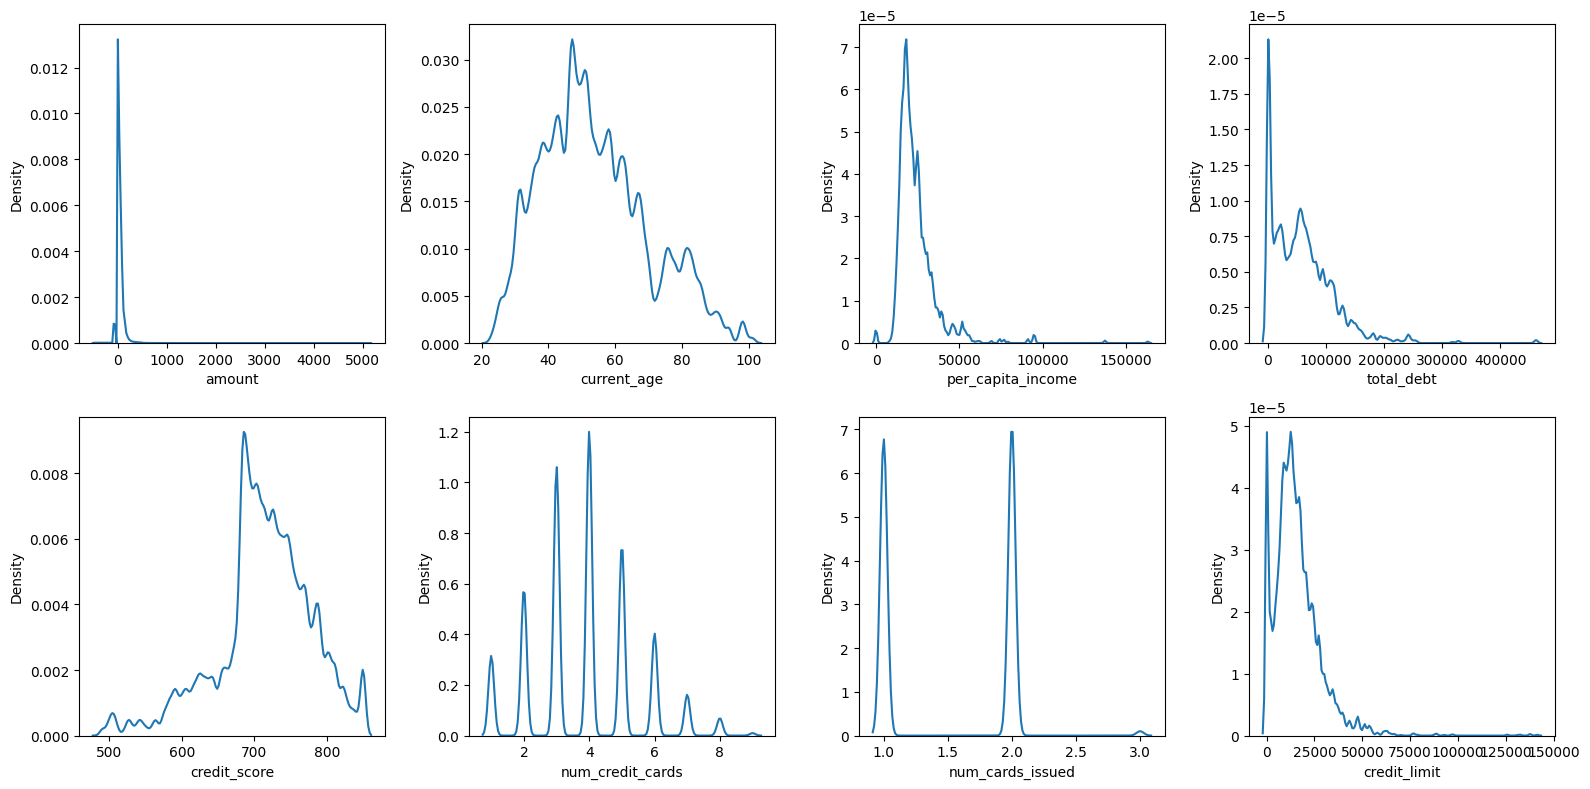

In [ ]:
# displot for numerical features
rcParams['figure.figsize'] = 16, 8
for i in numerical_features:
  plt.subplot(2, 4, numerical_features.index(i) + 1)
  sns.kdeplot(data = data_train, x = i)
  plt.tight_layout()

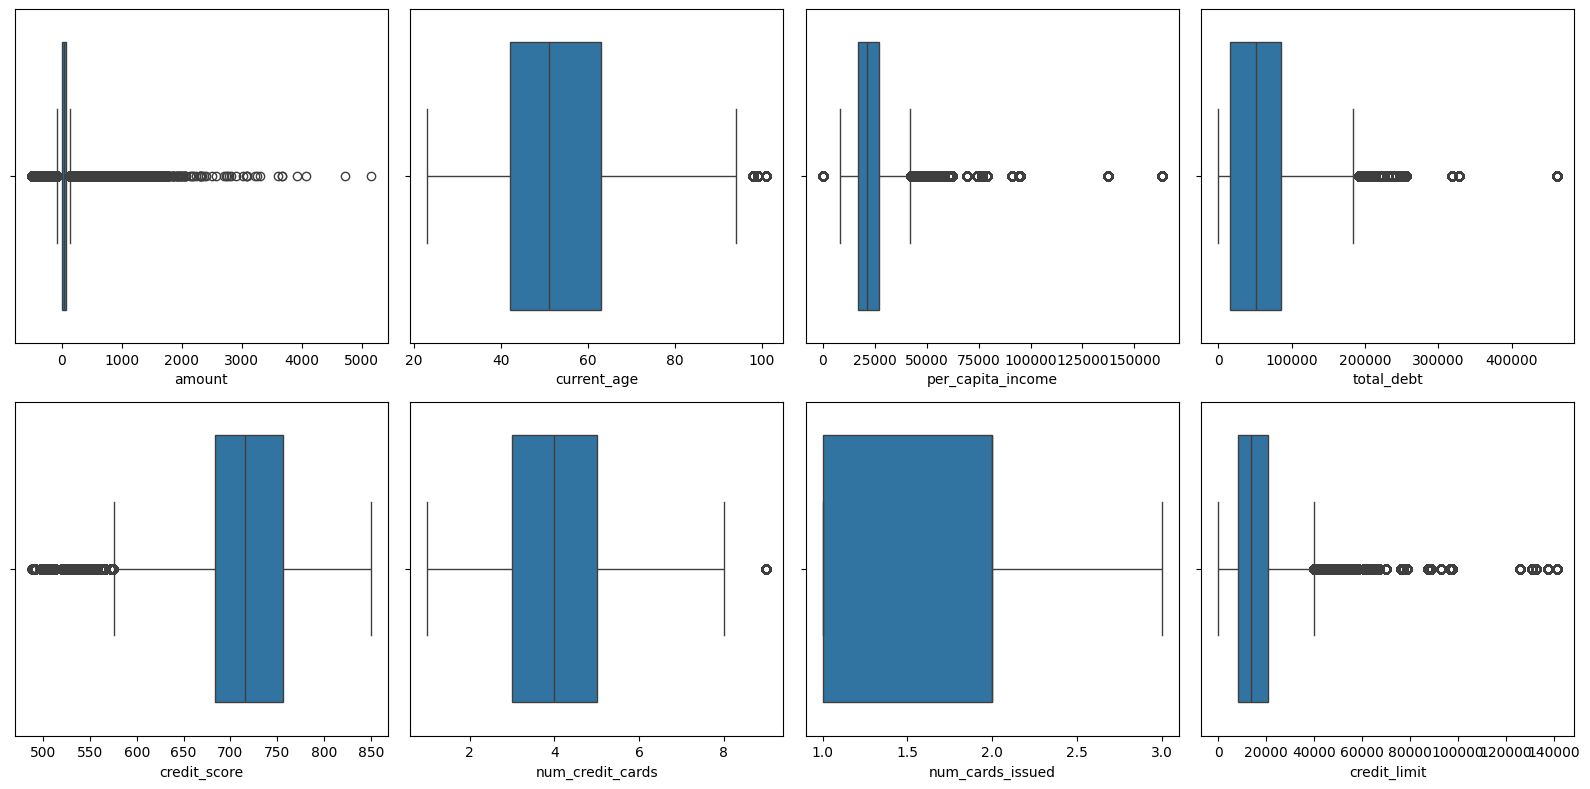

In [ ]:
# boxplot for each numerical features
rcParams['figure.figsize'] = 16, 8
for i in numerical_features:
  plt.subplot(2, 4, numerical_features.index(i) + 1)
  sns.boxplot(x = data_train[i])
  plt.tight_layout()

There are outliers in each feature except `num_cards_issued`

**Summary**
- There is no missing values and duplicates row in this dataset.
- If there is any missing values in data test or data validation, we will use each feature's central tendency to imputation.
  - amount: median
  - current_age: mean
  - per_capita_income: median
  - total_debt: median
  - credit_score: mean
  - num_credit_cards: mode
  - num_cards_issued: mode
  - credit_limit: median
- There are outliers for each features except num_cards_issued. Further review will be conducted regarding outliers in each feature.

### 5.2.2 Bivariate Analysis

In [ ]:
# bivariate correlation for numerical features and target feature
data_train[numerical_features].corr()

,amount,current_age,per_capita_income,total_debt,credit_score,num_credit_cards,num_cards_issued,credit_limit
amount,1.000000,-0.003469,0.105246,0.043605,-0.014658,-0.007673,0.002578,0.065329
current_age,-0.003469,1.000000,0.009399,-0.380095,-0.021594,0.387740,0.013759,-0.036888
per_capita_income,0.105246,0.009399,1.000000,0.427991,-0.049961,0.015730,0.007604,0.606028
total_debt,0.043605,-0.380095,0.427991,1.000000,-0.120015,-0.205165,0.021228,0.276610
credit_score,-0.014658,-0.021594,-0.049961,-0.120015,1.000000,0.244272,-0.075749,0.028535
num_credit_cards,-0.007673,0.387740,0.015730,-0.205165,0.244272,1.000000,-0.091209,0.065922
num_cards_issued,0.002578,0.013759,0.007604,0.021228,-0.075749,-0.091209,1.000000,-0.073168
credit_limit,0.065329,-0.036888,0.606028,0.276610,0.028535,0.065922,-0.073168,1.000000


No pair in the bivariate correlation has a correlation coeffient that higher than 0.8

Notice that `credit_limit` and `per_capita_income` have a correlation coefficient of *0.606028*. This indicates that these features have a moderately strong positive linear relationship.

For example, it suggests that customers with higher `per_capita_income` tend to have higher `credit_limit` values.

## 5.3 Analysis for Categorical Features

### 5.3.1 Univariate Analysis

**Value Counts checking for each features**

In [ ]:
print(f'X_train data shape: {len(data_train)}')
print('')

for i in nominal_features:
  print(data_train[i].value_counts())
  print('')

X_train data shape: 1870036

use_chip
Chip Transaction      1328639
Swipe Transaction      314005
Online Transaction     227392
Name: count, dtype: int64

card_type
Debit              1174175
Credit              567492
Debit (Prepaid)     128369
Name: count, dtype: int64

gender
Female    961791
Male      908245
Name: count, dtype: int64

has_chip
YES    1685597
NO      184439
Name: count, dtype: int64



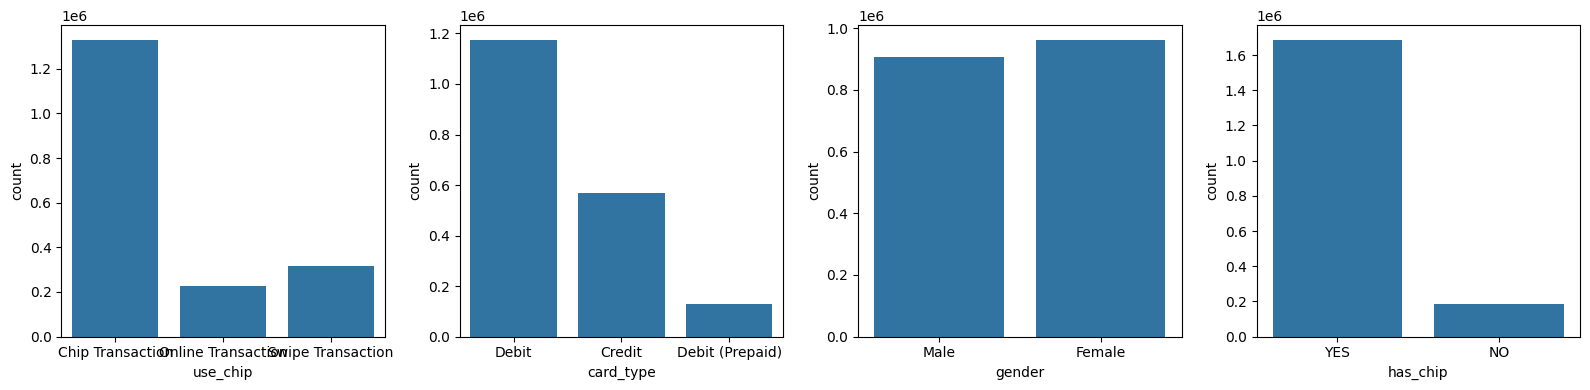

In [ ]:
# countplot for each categorical features
rcParams['figure.figsize'] = 16, 4
for i in nominal_features:
  plt.subplot(1, 4, nominal_features.index(i) + 1)
  sns.countplot(x = data_train[i])
  plt.tight_layout()

### 5.3.2 Bivariate Analysis

We will use Chi-Square Test of Independence to test whether two categorical variables are dependent or not.

<center>
$ H_0: $ Two categorical features are independent <br>
$ H_0: $ Two categorical features are dependent

If there are features that are dependent, Cramer's V calculation will be performed to determine the strength of the association between the two features.

In [ ]:
import scipy.stats as st
from scipy.stats import chi2_contingency

In [ ]:
def hypothesis_test(data, feature_a, feature_b):
  # create contigency_table
  contingency_table = pd.crosstab(data[feature_a], data[feature_b])

  # chi-square test of independence
  chi2, p_value, dof, expected = chi2_contingency(contingency_table)
  print(f'p-value: {p_value}')

  # hypothesis result
  if p_value >= 0.05:
    print(f'Accept H0, feature {i} is independent with {j}')
  else:
    print(f'Reject H0, feature {i} is dependen with {j}')

  # calculate Cramer's V
  n = contingency_table.sum().sum()
  min_dim = min(contingency_table.shape) - 1
  cramers_v = np.sqrt((chi2 / (n * min_dim)))
  print(f'Cramer\'s V: {cramers_v}')

  # interprete
  if cramers_v < 0.2:
    print('The relationship between the two features is weak.')
  elif cramers_v < 0.4:
    print('The relationship between the two features is moderate.')
  elif cramers_v < 0.6:
    print('The relationship between the two features is strong.')
  else:
    print('The relationship between the two features is very strong.')

In [ ]:
# hypothesis testing for each nominal features
for i in nominal_features:
  print('_________________________________________________')
  print('')

  for j in nominal_features:
    if (i != j):
      print(f'Feature {i} vs Feature {j}')
      print('-------------------------------------------------')

      hypothesis_test(data_train, i, j)
      print('')

_________________________________________________

Feature use_chip vs Feature card_type
-------------------------------------------------
p-value: 3.398977149420737e-106
Reject H0, feature use_chip is dependen with card_type
Cramer's V: 0.011524554107927349
The relationship between the two features is weak.

Feature use_chip vs Feature gender
-------------------------------------------------
p-value: 2.586086564082839e-202
Reject H0, feature use_chip is dependen with gender
Cramer's V: 0.022280734520446606
The relationship between the two features is weak.

Feature use_chip vs Feature has_chip
-------------------------------------------------
p-value: 0.0
Reject H0, feature use_chip is dependen with has_chip
Cramer's V: 0.6428802338101992
The relationship between the two features is very strong.

_________________________________________________

Feature card_type vs Feature use_chip
-------------------------------------------------
p-value: 3.3989771494208334e-106
Reject H0, feature 

The relationship between features `has_chip` and `use_chip` is strong. We can drop one of the features during feature selection if necessary.

## 5.4 Analysis for Features and Target

### 5.4.1 T-Test for Numerical Features

In [ ]:
from scipy.stats import ttest_ind

In [ ]:
# t-test hypothesis
def hypothesis_test_t(data, feature, target):
  for i in feature:
    data_fraud = data[data[target] == 1][i]
    data_not_fraud = data[data[target] == 0][i]

    print(f'Feature {i}')
    print('-------------------------------------------------')

    stat, p = ttest_ind(data_fraud, data_not_fraud)
    print(f'T-test statistic: {stat: .3f}, p-value: {p: .3f}')

    if p >= 0.05:
      print(f'Accept H0, feature {i} is independent with target')
    else:
      print(f'Reject H0, feature {i} is dependen with target')

    print('')

In [ ]:
hypothesis_test_t(data_train, numerical_features, 'is_fraudulent')

Feature amount
-------------------------------------------------
T-test statistic:  52.072, p-value:  0.000
Reject H0, feature amount is dependen with target

Feature current_age
-------------------------------------------------
T-test statistic:  4.361, p-value:  0.000
Reject H0, feature current_age is dependen with target

Feature per_capita_income
-------------------------------------------------
T-test statistic: -3.384, p-value:  0.001
Reject H0, feature per_capita_income is dependen with target

Feature total_debt
-------------------------------------------------
T-test statistic: -3.197, p-value:  0.001
Reject H0, feature total_debt is dependen with target

Feature credit_score
-------------------------------------------------
T-test statistic:  4.458, p-value:  0.000
Reject H0, feature credit_score is dependen with target

Feature num_credit_cards
-------------------------------------------------
T-test statistic:  10.166, p-value:  0.000
Reject H0, feature num_credit_cards is 

All numerical features except for feature `num_cards_issued` show dependency with the target feature `is_fraudulent`.

### 5.4.2 Chi-Squared for Nominal Features

In [ ]:
# hypothesis testing between nominal features and is_fraudulent
for i in nominal_features:
  hypothesis_test(data_train, i, 'is_fraudulent')
  print('')

p-value: 0.0
Reject H0, feature use_chip is dependen with has_chip
Cramer's V: 0.07779080136370958
The relationship between the two features is weak.

p-value: 8.292143559066132e-06
Reject H0, feature card_type is dependen with has_chip
Cramer's V: 0.003537420554900147
The relationship between the two features is weak.

p-value: 0.04198473523833487
Reject H0, feature gender is dependen with has_chip
Cramer's V: 0.0014871535169497677
The relationship between the two features is weak.

p-value: 0.39738795535247906
Accept H0, feature has_chip is independent with has_chip
Cramer's V: 0.0006188665553307213
The relationship between the two features is weak.



All nominal features (except `has_chip`) show dependency with the target feature `is_fraudulent`, although it is relatively weak.

## 5.5 Reduce RAM Usages

In [ ]:
%whos DataFrame

Variable     Type         Data/Info
-----------------------------------
X_test       DataFrame                            d<...>855968 rows x 15 columns]
X_train      DataFrame                            d<...>870036 rows x 15 columns]
X_valid      DataFrame                            d<...>855967 rows x 15 columns]
data_train   DataFrame                            d<...>870036 rows x 16 columns]


In [ ]:
# delete not used dataset to reduce ram usages
del data_train
import gc
gc.collect()

611

# <font color = 'blue'> 6. Data Pre-Processing
---

## 6.1 Data Pre-Processing

**Feature Engineering: Create Aggregation Table Based On Feature: Date**

In [66]:
# calculate aggregation table

def create_agg_table(data,
                     groupby = 'client_id',
                     date_col = 'date',
                     amount_col = 'amount',
                     windows = ['30d']):

  data = data.copy()

  data[date_col] = pd.to_datetime(data[date_col])
  data = data.sort_values([groupby, date_col])

  # NEW FEATURES

  # client_total_amount: the cumulative total transaction amount per client up to the current transaction
  data['client_total_amount'] = (data.groupby(groupby)[amount_col]
                                 .expanding().sum().reset_index(level = 0, drop = True).to_numpy())

  # client_avg_amount: the historical average transaction amount of the user
  data['client_avg_amount'] = (data.groupby(groupby)[amount_col]
                               .expanding().mean().reset_index(level = 0, drop = True).to_numpy())

  # client_std_amount: the standard deviation of the user's transaction amounts
  data['client_std_amount'] = (data.groupby(groupby)[amount_col]
                               .expanding().std().reset_index(level = 0, drop = True).to_numpy())

  # days_since_last_tx: the difference in days between consecutive transactions of each user
  data['days_since_last_tx'] = (data.groupby(groupby)[date_col]
                                .diff().dt.days)

  # amount_delta: the difference in transaction amount from the previous transaction (increase or decrease) for each client.
  data['amount_delta'] = (data.groupby(groupby)[amount_col].diff())


  data = data.set_index(date_col)


  for window in windows:
    # Rolling sum: the total transaction amount of each client over the past 7/30 days.
    data[f'rolling_sum_{window}'] = (data.groupby(groupby)[amount_col]
                                     .rolling(window, closed = 'left')
                                     .sum()
                                     .reset_index(level = 0, drop = True).to_numpy())

    # Rolling mean: the average transaction amount of each client over the past 7/30 days
    data[f'rolling_mean_{window}'] = (data.groupby(groupby)[amount_col]
                                      .rolling(window, closed = 'left')
                                      .mean()
                                      .reset_index(level = 0, drop = True).to_numpy())

    # Rolling count: the total number of transactions made by each client over the past 7/30 days
    data[f'rolling_count_{window}'] = (data.groupby(groupby)[amount_col]
                                       .rolling(window, closed = 'left')
                                       .count()
                                       .reset_index(level = 0, drop = True).to_numpy())

    # Rolling std: the variation in transaction amounts made by each client over the past 7/30 days
    data[f'rolling_std_{window}'] = (data.groupby(groupby)[amount_col]
                                     .rolling(window, closed = 'left')
                                     .std()
                                     .reset_index(level = 0, drop = True).to_numpy())


  data = data.reset_index()


  # Handle NaN
  fill_zero_cols = ['client_std_amount', 'days_since_last_tx', 'amount_delta'] + \
                   [col for col in data.columns if 'std' in col]

  for col in fill_zero_cols:
    data[col] = data[col].fillna(0)

  fill_amount_cols = ['client_total_amount', 'client_avg_amount'] + \
                     [col for col in data.columns if 'rolling_sum' in col or 'rolling_mean' in col or 'rolling_count' in col]

  for col in fill_amount_cols:
        data[col] = data[col].fillna(data[amount_col])


  return data

**Data Cleaning, Feature Engineering, Data Transformation**

In [67]:
# import libraries for yeo-johnson transformation, standardization
from sklearn.preprocessing import PowerTransformer, StandardScaler

def data_pre_processing(data,
                        numerical_features = numerical_features,
                        nominal_features = nominal_features):

  data_processed = data.copy()

  # DATA CLEANING: missing values imputation
  for i in numerical_features:
    data_processed[i].fillna(data_processed[i].median(), inplace = True)
  for i in nominal_features:
    data_processed[i].fillna(data_processed[i].mode()[0], inplace = True)

  # FEATURE ENGINEERING: extract information from feature `date`
  data_processed['dayofweek'] = data_processed['date'].dt.dayofweek
  data_processed['hour'] = data_processed['date'].dt.hour
  data_processed['is_weekend'] = data_processed['dayofweek'].isin([5,6]).astype(int)
  data_processed['is_work_hour'] = data_processed['hour'].between(9, 17).astype(int)
  data_processed.drop(columns = ['dayofweek', 'hour'], inplace = True)

  # FEATURE ENGINEERING: create aggregation table
  data_processed = create_agg_table(data_processed)

  # assign column with type int/float into num_features
  num_features = data_processed.select_dtypes(include = ['int32', 'float32', 'int64', 'float64']).columns.tolist()

  '''
  # assign skewed features
  feature_to_transform = []
  for i in num_features:
    # if skewness > 1, do the feature transformation with yeo-johnson
    if abs(data_processed[i].skew()) > 1:
      # append i to feature_to_transform
      feature_to_transform.append(i)


  # FEATURE TRANSFORMATION: yeo-johnson transformation
  pt = PowerTransformer(method = 'yeo-johnson', standardize = False)
  data_processed = pt.fit_transform(data_processed[num_features])

  # rename all features in feature_to_transform by adding '_yj'
  for i in num_features:
    data_processed.rename(columns = {i: i + '_yj'}, inplace = True)

  num_features = data_processed.select_dtypes(include = ['int32', 'float32', 'int64', 'float64']).columns.tolist()
  '''

  return data_processed, num_features

In [68]:
X_train_processed, num = data_pre_processing(X_train)

# set 'id' column as index
X_train_processed.set_index('row_id', inplace = True)

X_train_processed.head()

/tmp/ipython-input-3683576218.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_processed[i].fillna(data_processed[i].median(), inplace = True)
/tmp/ipython-input-3683576218.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

,date,client_id,card_id,use_chip,amount,current_age,gender,per_capita_income,total_debt,credit_score,...,is_work_hour,client_total_amount,client_avg_amount,client_std_amount,days_since_last_tx,amount_delta,rolling_sum_30d,rolling_mean_30d,rolling_count_30d,rolling_std_30d
row_id,,,,,,,,,,,,,,,,,,,,,
17174506,2016-01-01 11:20:00,1,4400,Online Transaction,26.940001,43,Female,22247.0,14587.0,704.0,...,1,26.940001,26.940001,0.000000,0.0,0.000000,26.940001,26.940001,26.940001,0.000000
17174747,2016-01-01 11:58:00,1,4652,Online Transaction,13.570000,43,Female,22247.0,14587.0,704.0,...,1,40.510000,20.255000,9.454018,0.0,-13.370001,26.940001,26.940001,1.000000,0.000000
17176175,2016-01-01 16:29:00,1,4400,Online Transaction,11.880000,43,Female,22247.0,14587.0,704.0,...,1,52.390000,17.463333,8.250421,0.0,-1.690000,40.510000,20.255000,2.000000,9.454018
17180656,2016-01-02 16:27:00,1,4652,Online Transaction,17.920000,43,Female,22247.0,14587.0,704.0,...,1,70.310000,17.577500,6.740309,0.0,6.040000,52.390000,17.463333,3.000000,8.250421
17180781,2016-01-02 16:51:00,1,4400,Online Transaction,14.280000,43,Female,22247.0,14587.0,704.0,...,1,84.590000,16.918000,6.020675,0.0,-3.640000,70.310000,17.577500,4.000000,6.740309


In [69]:
num

['amount',
 'current_age',
 'per_capita_income',
 'total_debt',
 'credit_score',
 'num_credit_cards',
 'num_cards_issued',
 'credit_limit',
 'is_weekend',
 'is_work_hour',
 'client_total_amount',
 'client_avg_amount',
 'client_std_amount',
 'days_since_last_tx',
 'amount_delta',
 'rolling_sum_30d',
 'rolling_mean_30d',
 'rolling_count_30d',
 'rolling_std_30d']

**Reduce RAM Usages**

In [70]:
# change all dtype float64 to float32, int64 to int32
def reduce_ram_usage(data):
  for col in data.columns:
    if data[col].dtype == 'float64':
      data[col] = data[col].astype('float32')
    if data[col].dtype == 'int64':
      data[col] = data[col].astype('int32')
  return data

In [71]:
X_train_processed = reduce_ram_usage(X_train_processed)
X_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1870046 entries, 17174506 to 20604283
Data columns (total 26 columns):
 #   Column               Dtype         
---  ------               -----         
 0   date                 datetime64[ns]
 1   client_id            object        
 2   card_id              object        
 3   use_chip             object        
 4   amount               float32       
 5   current_age          int32         
 6   gender               object        
 7   per_capita_income    float32       
 8   total_debt           float32       
 9   credit_score         float32       
 10  num_credit_cards     int32         
 11  card_type            object        
 12  has_chip             object        
 13  num_cards_issued     int32         
 14  credit_limit         float32       
 15  is_weekend           int32         
 16  is_work_hour         int32         
 17  client_total_amount  float32       
 18  client_avg_amount    float32       
 19  client_std_amount 

## 6.2 Outlier Detection

**Outlier Detection using Isolation Forest**

In fraud detection datasets, outliers may indicate suspicious or anomalous activity. Hence, removing or altering these extreme values could lead to the loss of critical information and should be avoided.

In [72]:
# flag outlier using isolation forest
from sklearn.ensemble import IsolationForest

def mark_outliers(data, features = num):
  data_outlier = data[features].copy()

  # create isolation forest model
  iso_forest = IsolationForest(contamination = 0.2, random_state = 42)

  data_outlier['anomaly_score'] = iso_forest.fit_predict(data_outlier)
  data_outlier['is_anomaly'] = (data_outlier['anomaly_score'] == -1).astype(int)

  return data_outlier

In [73]:
# mark outlier in data_train
X_num_processed = mark_outliers(X_train_processed, num)
X_num_processed.head()

,amount,current_age,per_capita_income,total_debt,credit_score,num_credit_cards,num_cards_issued,credit_limit,is_weekend,is_work_hour,...,client_avg_amount,client_std_amount,days_since_last_tx,amount_delta,rolling_sum_30d,rolling_mean_30d,rolling_count_30d,rolling_std_30d,anomaly_score,is_anomaly
row_id,,,,,,,,,,,,,,,,,,,,,
17174506,26.940001,43,22247.0,14587.0,704.0,3,1,18105.0,0,1,...,26.940001,0.000000,0.0,0.000000,26.940001,26.940001,26.940001,0.000000,1,0
17174747,13.570000,43,22247.0,14587.0,704.0,3,1,12800.0,0,1,...,20.255001,9.454019,0.0,-13.370001,26.940001,26.940001,1.000000,0.000000,1,0
17176175,11.880000,43,22247.0,14587.0,704.0,3,1,18105.0,0,1,...,17.463333,8.250421,0.0,-1.690000,40.510002,20.255001,2.000000,9.454019,1,0
17180656,17.920000,43,22247.0,14587.0,704.0,3,1,12800.0,1,1,...,17.577499,6.740309,0.0,6.040000,52.389999,17.463333,3.000000,8.250421,-1,1
17180781,14.280000,43,22247.0,14587.0,704.0,3,1,18105.0,1,1,...,16.917999,6.020675,0.0,-3.640000,70.309998,17.577499,4.000000,6.740309,-1,1


In [74]:
# how many anomaly rows?
X_num_processed['is_anomaly'].value_counts(normalize = True)

,proportion
is_anomaly,
0,0.8
1,0.2


## 6.3 Standardization

In [75]:
# boolean features
bool_features = ['is_weekend', 'is_work_hour', 'is_anomaly']

In [76]:
# standardization for non boolean numerical features
def standardization(data, features):
  scaler = StandardScaler()
  data[features] = scaler.fit_transform(data[features])
  return data

In [77]:
# standardization here
X_num_processed = standardization(X_num_processed,
                                  features = [col for col in num if col not in bool_features])
X_num_processed.head()

,amount,current_age,per_capita_income,total_debt,credit_score,num_credit_cards,num_cards_issued,credit_limit,is_weekend,is_work_hour,...,client_avg_amount,client_std_amount,days_since_last_tx,amount_delta,rolling_sum_30d,rolling_mean_30d,rolling_count_30d,rolling_std_30d,anomaly_score,is_anomaly
row_id,,,,,,,,,,,,,,,,,,,,,
17174506,-0.194742,-0.675083,-0.144445,-0.837821,-0.149736,-0.524827,-1.014479,0.201559,0,1,...,-0.893474,-2.469911,-0.313989,-0.000076,-1.515918,-0.795418,-1.208556,-1.736517,1,0
17174747,-0.358694,-0.675083,-0.144445,-0.837821,-0.149736,-0.524827,-1.014479,-0.234995,0,1,...,-1.268477,-2.155548,-0.313989,-0.116155,-1.515918,-0.795418,-1.826552,-1.736517,1,0
17176175,-0.379418,-0.675083,-0.144445,-0.837821,-0.149736,-0.524827,-1.014479,0.201559,0,1,...,-1.425079,-2.195570,-0.313989,-0.014749,-1.509532,-1.129406,-1.802728,-1.499261,1,0
17180656,-0.305351,-0.675083,-0.144445,-0.837821,-0.149736,-0.524827,-1.014479,-0.234995,1,1,...,-1.418675,-2.245784,-0.313989,0.052364,-1.503940,-1.268881,-1.778904,-1.529467,-1,1
17180781,-0.349987,-0.675083,-0.144445,-0.837821,-0.149736,-0.524827,-1.014479,0.201559,1,1,...,-1.455670,-2.269713,-0.313989,-0.031679,-1.495506,-1.263177,-1.755080,-1.567364,-1,1


## 6.4 Nominal Features Encoding

**Encoding with One-Hot Encoding**

In [78]:
# import library for OHE
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoding(data, features = nominal_features):
    '''
    Function to encode

    Parameters
    ----------
    data      : pd.DataFrame
              The input data

    features  : list
              Nominal features that will be encoded

    Returns
    -------
    data_encoded  : pd.DataFrame
                  The input encoded data
    '''

    # create dataset for nominal_features
    data_subset = data[features].copy()

    # initiate encoder
    encoder = OneHotEncoder(drop = 'if_binary',
                            handle_unknown = 'ignore')

    # fit encoder to nominal features in the data
    encoder.fit(data_subset)

    # transfrom
    data_subset_enc = pd.DataFrame(
        encoder.transform(data_subset).toarray(),
        columns = encoder.get_feature_names_out(),
        index = data_subset.index
    )

    return data_subset_enc

In [79]:
# encode here
X_nom_processed = one_hot_encoding(X_train_processed, nominal_features)
X_nom_processed.head()

,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction,card_type_Credit,card_type_Debit,card_type_Debit (Prepaid),gender_Male,has_chip_YES
row_id,,,,,,,,
17174506,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
17174747,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
17176175,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
17180656,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
17180781,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


## 6.5 Merge Numerical, Nominal, and Target Feature then Re-Splitting It

To ensure that the indexes between the dataframe X and the target output y match, the data will be concatenated and then split again.

In [80]:
def concat_then_split(X_num, X_nom, y, target):
  data = pd.concat([X_num, X_nom, y], axis = 1)
  X_train, y_train = data.drop(columns = [target]), data[target]
  return X_train, y_train

In [81]:
X_train_processed, y_train = concat_then_split(X_num_processed,
                                               X_nom_processed,
                                               y_train,
                                               target = 'is_fraudulent')

X_train_processed.head()

,amount,current_age,per_capita_income,total_debt,credit_score,num_credit_cards,num_cards_issued,credit_limit,is_weekend,is_work_hour,...,anomaly_score,is_anomaly,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction,card_type_Credit,card_type_Debit,card_type_Debit (Prepaid),gender_Male,has_chip_YES
17174506,-0.194742,-0.675083,-0.144445,-0.837821,-0.149736,-0.524827,-1.014479,0.201559,0,1,...,1,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
17174747,-0.358694,-0.675083,-0.144445,-0.837821,-0.149736,-0.524827,-1.014479,-0.234995,0,1,...,1,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
17176175,-0.379418,-0.675083,-0.144445,-0.837821,-0.149736,-0.524827,-1.014479,0.201559,0,1,...,1,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
17180656,-0.305351,-0.675083,-0.144445,-0.837821,-0.149736,-0.524827,-1.014479,-0.234995,1,1,...,-1,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
17180781,-0.349987,-0.675083,-0.144445,-0.837821,-0.149736,-0.524827,-1.014479,0.201559,1,1,...,-1,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [82]:
y_train.head()

,is_fraudulent
17174506,0
17174747,0
17176175,0
17180656,0
17180781,0


In [83]:
X_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1870046 entries, 17174506 to 20604283
Data columns (total 29 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   amount                       float64
 1   current_age                  float64
 2   per_capita_income            float64
 3   total_debt                   float64
 4   credit_score                 float64
 5   num_credit_cards             float64
 6   num_cards_issued             float64
 7   credit_limit                 float64
 8   is_weekend                   int32  
 9   is_work_hour                 int32  
 10  client_total_amount          float64
 11  client_avg_amount            float64
 12  client_std_amount            float64
 13  days_since_last_tx           float64
 14  amount_delta                 float64
 15  rolling_sum_30d              float64
 16  rolling_mean_30d             float64
 17  rolling_count_30d            float64
 18  rolling_std_30d              float64
 1

## 6.6 Feature Correlation

**Pearson Correlation**

In [ ]:
from scipy.stats import pearsonr

corr_scores = {}
for col in X_train_processed.columns:
    corr, _ = pearsonr(X_train_processed[col], y_train)
    corr_scores[col] = abs(corr)

corr_series = pd.Series(corr_scores).sort_values(ascending = False)
print('Features with the Highest Pearson Correlation:')
print(corr_series.head(10))

# filter the features by its threshold (> 0.1)
# selected_features = corr_series[corr_series > 0.1].index.tolist()


Features with the Highest Pearson Correlation:
use_chip_Online Transaction    0.077751
use_chip_Chip Transaction      0.047330
amount_yj                      0.035687
client_total_amount_yj         0.026022
is_work_hour                   0.024262
rolling_count_30d_yj           0.015057
amount_delta                   0.014220
is_anomaly                     0.012116
anomaly_score                  0.012116
use_chip_Swipe Transaction     0.010554
dtype: float64


In [ ]:
# mutual information
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X_train_processed, y_train, discrete_features = 'auto', random_state = 42)
mi_series = pd.Series(mi, index = X_train_processed.columns).sort_values(ascending = False)
print('Features with the Highest Mutual Information:')
print(mi_series.head(10))

# opsional: threshold
# selected_mi = mi_series[mi_series > 0.01].index.tolist()


Features with the Highest Mutual Information:
has_chip_YES                 0.251418
anomaly_score                0.248123
use_chip_Chip Transaction    0.202180
num_cards_issued             0.201396
card_type_Debit              0.172796
is_work_hour                 0.155457
gender_Male                  0.133118
days_since_last_tx_yj        0.129865
card_type_Credit             0.085338
is_weekend                   0.077227
dtype: float64


## 6.7 Reduce RAM Usages

In [84]:
# change dtype
X_train_processed = reduce_ram_usage(X_train_processed)
X_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1870046 entries, 17174506 to 20604283
Data columns (total 29 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   amount                       float32
 1   current_age                  float32
 2   per_capita_income            float32
 3   total_debt                   float32
 4   credit_score                 float32
 5   num_credit_cards             float32
 6   num_cards_issued             float32
 7   credit_limit                 float32
 8   is_weekend                   int32  
 9   is_work_hour                 int32  
 10  client_total_amount          float32
 11  client_avg_amount            float32
 12  client_std_amount            float32
 13  days_since_last_tx           float32
 14  amount_delta                 float32
 15  rolling_sum_30d              float32
 16  rolling_mean_30d             float32
 17  rolling_count_30d            float32
 18  rolling_std_30d              float32
 1

In [85]:
%whos DataFrame

Variable            Type         Data/Info
------------------------------------------
X_nom_processed     DataFrame              use_chip_Chip T<...>1870046 rows x 8 columns]
X_num_processed     DataFrame                amount  curre<...>870046 rows x 21 columns]
X_test              DataFrame                            d<...>855969 rows x 16 columns]
X_train             DataFrame                            d<...>870046 rows x 16 columns]
X_train_processed   DataFrame                amount  curre<...>870046 rows x 29 columns]
X_valid             DataFrame                            d<...>855969 rows x 16 columns]
data_train          DataFrame                            d<...>870046 rows x 17 columns]


In [86]:
# delete not used dataset to reduce ram usages
del X_nom_processed, X_num_processed, X_train, data_train
import gc
gc.collect()

23

## 6.8 Data Balancing

### 6.8.1 Random Undersampling

In [87]:
from imblearn.under_sampling import RandomUnderSampler

def rus_fit_resample(x, y):

    # Create copy of set data
    x = x.copy()
    y = y.copy()

    # Create sampling object
    rus = RandomUnderSampler(random_state = 42)

    # Balancing data set
    x_rus, y_rus = rus.fit_resample(x, y)

    # Return balanced data set
    return x_rus, y_rus

In [88]:
# Perform RUS
x_rus, y_rus = rus_fit_resample(x = X_train_processed,
                                y = y_train)

In [89]:
# Check the balanced response
y_rus.value_counts()

,count
is_fraudulent,
0,2620
1,2620


### 6.8.2 Random Oversampling

In [90]:
from imblearn.over_sampling import RandomOverSampler

def ros_fit_resample(x,y):

    # Create copy of set data
    x = x.copy()
    y = y.copy()

    # Create sampling object
    ros = RandomOverSampler(random_state = 42)

    # Balancing data set
    x_ros, y_ros = ros.fit_resample(x, y)

    # Return balanced data set
    return x_ros, y_ros


In [91]:
# Perform ROS
x_ros, y_ros = ros_fit_resample(x = X_train_processed,
                                  y = y_train)

In [92]:
# Check the balanced response
y_ros.value_counts()

,count
is_fraudulent,
0,1867426
1,1867426


## 6.9 DataFrame Checking

In [93]:
%whos DataFrame

Variable            Type         Data/Info
------------------------------------------
X_test              DataFrame                            d<...>855969 rows x 16 columns]
X_train_processed   DataFrame                amount  curre<...>870046 rows x 29 columns]
X_valid             DataFrame                            d<...>855969 rows x 16 columns]
x_ros               DataFrame               amount  curren<...>734852 rows x 29 columns]
x_rus               DataFrame                amount  curre<...>n[5240 rows x 29 columns]


In [94]:
%whos Series

Variable   Type      Data/Info
------------------------------
y_ros      Series    0          0\n1          <...>th: 3734852, dtype: int64
y_rus      Series    19570345    0\n18157573  <...>ength: 5240, dtype: int64
y_test     Series    id\n22678245    0\n213685<...>gth: 855969, dtype: int64
y_train    Series    17174506    0\n17174747  <...>th: 1870046, dtype: int64
y_valid    Series    id\n23588775    0\n227150<...>gth: 855969, dtype: int64


## 6.10 Data Processing for X_valid and X_test

In [95]:
def process_the_data(X, y):

  # feature engineering
  X_processed, num = data_pre_processing(X)
  X_processed.set_index('row_id', inplace = True)

  # outlier detection
  X_num_processed = mark_outliers(X_processed, num)

  # standardization
  X_num_processed = standardization(X_num_processed,
                                    features = [col for col in num if col not in bool_features])

  # feature encoding
  X_nom_processed = one_hot_encoding(X_processed, nominal_features)

  # concat the numerical, nominal, target, then resplitting into input and output
  X_processed, y = concat_then_split(X_num_processed,
                                     X_nom_processed,
                                     y,
                                     target = 'is_fraudulent')

  # reduce ram usages
  X_processed = reduce_ram_usage(X_processed)

  return X_processed, y


### 6.10.1 X_valid

In [96]:
X_valid_processed, y_valid = process_the_data(X_valid, y_valid)

/tmp/ipython-input-3683576218.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_processed[i].fillna(data_processed[i].median(), inplace = True)
/tmp/ipython-input-3683576218.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

In [97]:
X_valid_processed.head()

,amount,current_age,per_capita_income,total_debt,credit_score,num_credit_cards,num_cards_issued,credit_limit,is_weekend,is_work_hour,...,anomaly_score,is_anomaly,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction,card_type_Credit,card_type_Debit,card_type_Debit (Prepaid),gender_Male,has_chip_YES
20608426,-0.358738,-0.671431,-0.143944,-0.834119,-0.153706,-0.529334,-1.016372,-0.235844,0,1,...,1,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
20611992,0.702032,-0.671431,-0.143944,-0.834119,-0.153706,-0.529334,-1.016372,-0.235844,0,1,...,1,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
20613018,-0.470412,-0.671431,-0.143944,-0.834119,-0.153706,-0.529334,-1.016372,-0.235844,0,1,...,1,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
20616113,-0.415199,-0.671431,-0.143944,-0.834119,-0.153706,-0.529334,-1.016372,-0.235844,0,1,...,1,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
20619666,0.478061,-0.671431,-0.143944,-0.834119,-0.153706,-0.529334,-1.016372,-0.235844,0,0,...,1,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [98]:
y_valid.head()

,is_fraudulent
20608426,0
20611992,0
20613018,0
20616113,0
20619666,0


### 6.10.2 X_test

In [99]:
X_test_processed, y_test = process_the_data(X_test, y_test)

/tmp/ipython-input-3683576218.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_processed[i].fillna(data_processed[i].median(), inplace = True)
/tmp/ipython-input-3683576218.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

In [100]:
X_test_processed.head()

,amount,current_age,per_capita_income,total_debt,credit_score,num_credit_cards,num_cards_issued,credit_limit,is_weekend,is_work_hour,...,anomaly_score,is_anomaly,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction,card_type_Credit,card_type_Debit,card_type_Debit (Prepaid),gender_Male,has_chip_YES
20611474,-0.332056,-0.67163,-0.145521,-0.832956,-0.153131,-0.532418,-1.015912,-0.235867,0,1,...,1,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
20611805,0.212804,-0.67163,-0.145521,-0.832956,-0.153131,-0.532418,-1.015912,-0.235867,0,1,...,1,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
20613624,-0.393947,-0.67163,-0.145521,-0.832956,-0.153131,-0.532418,-1.015912,-0.235867,0,0,...,1,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
20617939,-0.284901,-0.67163,-0.145521,-0.832956,-0.153131,-0.532418,-1.015912,-0.235867,0,1,...,1,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
20623464,-0.358826,-0.67163,-0.145521,-0.832956,-0.153131,-0.532418,-1.015912,-0.235867,0,0,...,1,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [101]:
y_test.head()

,is_fraudulent
20611474,0
20611805,0
20613624,0
20617939,0
20623464,0


### 6.10.3 Dataframe Checking

In [102]:
%whos DataFrame

Variable            Type         Data/Info
------------------------------------------
X_test              DataFrame                            d<...>855969 rows x 16 columns]
X_test_processed    DataFrame                amount  curre<...>855969 rows x 29 columns]
X_train_processed   DataFrame                amount  curre<...>870046 rows x 29 columns]
X_valid             DataFrame                            d<...>855969 rows x 16 columns]
X_valid_processed   DataFrame                amount  curre<...>855969 rows x 29 columns]
x_ros               DataFrame               amount  curren<...>734852 rows x 29 columns]
x_rus               DataFrame                amount  curre<...>n[5240 rows x 29 columns]


In [103]:
%whos pd.Series

No variables match your requested type.


In [104]:
# delete not used dataset to reduce ram usages
del X_valid, X_test
import gc
gc.collect()

52

# <font color = 'blue'> 7. Data Modeling
---

In [109]:
# Import model

# baseline/interpretable
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

# tree-based ensemble models (non-linear, robust to outlier and imbalance)
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# evaluation score
from sklearn.metrics import f1_score, recall_score, precision_score, \
roc_auc_score, average_precision_score, classification_report

## 7.1 Baseline Model

### 7.1. Dataset Used: X_train (Imbalanced Dataset)

In [110]:
# model initialization
model_dict = {
    'baseline': DummyClassifier(random_state = 42),
    'logistic regression': LogisticRegression(random_state = 42,
                                              class_weight = 'balanced',
                                              n_jobs=-1),
    'decision tree': DecisionTreeClassifier(random_state = 42,
                                            class_weight = 'balanced'),
    'random forest': RandomForestClassifier(random_state = 42,
                                            class_weight = 'balanced',
                                            n_jobs=-1),
    'xgboost': XGBClassifier(random_state = 42,
                             scale_pos_weight = 600,
                             n_jobs=-1)
}

In [111]:
# train and evaluate each model

for model_name, model in model_dict.items():

    print(f'Training {model_name}...')
    model.fit(X_train_processed, y_train)

    y_pred = model.predict(X_valid_processed)
    y_proba = model.predict_proba(X_valid_processed)[:, 1] if hasattr(model, 'predict_proba') else None

    roc_auc = roc_auc_score(y_valid, y_proba) if y_proba is not None else None
    pr_auc = average_precision_score(y_valid, y_proba) if y_proba is not None else None

    recall = recall_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)

    print(f'ROC-AUC = {roc_auc:.4f}, PR-AUC = {pr_auc:.4f}')
    print(f'Recall (Fraud) = {recall:.4f}, Precision (Fraud) = {precision:.4f}, F1-Score = {f1:.4f}')
    print(classification_report(y_valid, y_pred, digits = 4))
    print('')

Training baseline...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ROC-AUC = 0.5000, PR-AUC = 0.0017
Recall (Fraud) = 0.0000, Precision (Fraud) = 0.0000, F1-Score = 0.0000
              precision    recall  f1-score   support

           0     0.9983    1.0000    0.9991    854474
           1     0.0000    0.0000    0.0000      1495

    accuracy                         0.9983    855969
   macro avg     0.4991    0.5000    0.4996    855969
weighted avg     0.9965    0.9983    0.9974    855969


Training logistic regression...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ROC-AUC = 0.5817, PR-AUC = 0.0021
Recall (Fraud) = 0.0883, Precision (Fraud) = 0.0014, F1-Score = 0.0028
              precision    recall  f1-score   support

           0     0.9982    0.8897    0.9408    854474
           1     0.0014    0.0883    0.0028      1495

    accuracy                         0.8883    855969
   macro avg     0.4998    0.4890    0.4718    855969
weighted avg     0.9965    0.8883    0.9392    855969


Training decision tree...
ROC-AUC = 0.5006, PR-AUC = 0.0018
Recall (Fraud) = 0.0027, Precision (Fraud) = 0.0034, F1-Score = 0.0030
              precision    recall  f1-score   support

           0     0.9983    0.9986    0.9984    854474
           1     0.0034    0.0027    0.0030      1495

    accuracy                         0.9969    855969
   macro avg     0.5008    0.5006    0.5007    855969
weighted avg     0.9965    0.9969    0.9967    855969


Training random forest...
ROC-AUC = 0.5219, PR-AUC = 0.0020
Recall (Fraud) = 0.0000, Precision (Fraud) = 0.0

### 7.1.2 Dataset Used: x_rus (Undersampling)

In [112]:
# model initialization
model_dict = {
    'baseline': DummyClassifier(random_state = 42),
    'logistic regression': LogisticRegression(random_state = 42),
    'decision tree': DecisionTreeClassifier(random_state = 42),
    'random forest': RandomForestClassifier(random_state = 42),
    'xgboost': XGBClassifier(random_state = 42),
    'svm': SVC(probability = True, random_state = 42)
}

In [113]:
# train and evaluate each model

for model_name, model in model_dict.items():

    print(f'Training {model_name}...')
    model.fit(x_rus, y_rus)

    y_pred = model.predict(X_valid_processed)
    y_proba = model.predict_proba(X_valid_processed)[:, 1] if hasattr(model, 'predict_proba') else None

    roc_auc = roc_auc_score(y_valid, y_proba) if y_proba is not None else None
    pr_auc = average_precision_score(y_valid, y_proba) if y_proba is not None else None

    recall = recall_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)

    print(f'ROC-AUC = {roc_auc:.4f}, PR-AUC = {pr_auc:.4f}')
    print(f'Recall (Fraud) = {recall:.4f}, Precision (Fraud) = {precision:.4f}, F1-Score = {f1:.4f}')
    print(classification_report(y_valid, y_pred, digits = 4))
    print('')

Training baseline...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ROC-AUC = 0.5000, PR-AUC = 0.0017
Recall (Fraud) = 0.0000, Precision (Fraud) = 0.0000, F1-Score = 0.0000
              precision    recall  f1-score   support

           0     0.9983    1.0000    0.9991    854474
           1     0.0000    0.0000    0.0000      1495

    accuracy                         0.9983    855969
   macro avg     0.4991    0.5000    0.4996    855969
weighted avg     0.9965    0.9983    0.9974    855969


Training logistic regression...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ROC-AUC = 0.5827, PR-AUC = 0.0021
Recall (Fraud) = 0.0983, Precision (Fraud) = 0.0015, F1-Score = 0.0030
              precision    recall  f1-score   support

           0     0.9982    0.8885    0.9402    854474
           1     0.0015    0.0983    0.0030      1495

    accuracy                         0.8871    855969
   macro avg     0.4999    0.4934    0.4716    855969
weighted avg     0.9965    0.8871    0.9385    855969


Training decision tree...
ROC-AUC = 0.5462, PR-AUC = 0.0020
Recall (Fraud) = 0.2602, Precision (Fraud) = 0.0027, F1-Score = 0.0054
              precision    recall  f1-score   support

           0     0.9984    0.8323    0.9078    854474
           1     0.0027    0.2602    0.0054      1495

    accuracy                         0.8313    855969
   macro avg     0.5006    0.5462    0.4566    855969
weighted avg     0.9967    0.8313    0.9062    855969


Training random forest...
ROC-AUC = 0.6000, PR-AUC = 0.0023
Recall (Fraud) = 0.1157, Precision (Fraud) = 0.0

### 7.1.3 Dataset Used: x_ros (Oversampling)

In [114]:
# model initialization
model_dict = {
    'baseline': DummyClassifier(random_state = 42),
    'logistic regression': LogisticRegression(random_state = 42),
    'decision tree': DecisionTreeClassifier(random_state = 42),
    'random forest': RandomForestClassifier(random_state = 42),
    'xgboost': XGBClassifier(random_state = 42)
}

In [115]:
# train and evaluate each model

for model_name, model in model_dict.items():

    print(f'Training {model_name}...')
    model.fit(x_ros, y_ros)

    y_pred = model.predict(X_valid_processed)
    y_proba = model.predict_proba(X_valid_processed)[:, 1] if hasattr(model, 'predict_proba') else None

    roc_auc = roc_auc_score(y_valid, y_proba) if y_proba is not None else None
    pr_auc = average_precision_score(y_valid, y_proba) if y_proba is not None else None

    recall = recall_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)

    print(f'ROC-AUC = {roc_auc:.4f}, PR-AUC = {pr_auc:.4f}')
    print(f'Recall (Fraud) = {recall:.4f}, Precision (Fraud) = {precision:.4f}, F1-Score = {f1:.4f}')
    print(classification_report(y_valid, y_pred, digits = 4))
    print('')

Training baseline...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ROC-AUC = 0.5000, PR-AUC = 0.0017
Recall (Fraud) = 0.0000, Precision (Fraud) = 0.0000, F1-Score = 0.0000
              precision    recall  f1-score   support

           0     0.9983    1.0000    0.9991    854474
           1     0.0000    0.0000    0.0000      1495

    accuracy                         0.9983    855969
   macro avg     0.4991    0.5000    0.4996    855969
weighted avg     0.9965    0.9983    0.9974    855969


Training logistic regression...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ROC-AUC = 0.5816, PR-AUC = 0.0021
Recall (Fraud) = 0.0883, Precision (Fraud) = 0.0014, F1-Score = 0.0028
              precision    recall  f1-score   support

           0     0.9982    0.8897    0.9408    854474
           1     0.0014    0.0883    0.0028      1495

    accuracy                         0.8883    855969
   macro avg     0.4998    0.4890    0.4718    855969
weighted avg     0.9965    0.8883    0.9392    855969


Training decision tree...
ROC-AUC = 0.5003, PR-AUC = 0.0017
Recall (Fraud) = 0.0020, Precision (Fraud) = 0.0026, F1-Score = 0.0023
              precision    recall  f1-score   support

           0     0.9983    0.9987    0.9985    854474
           1     0.0026    0.0020    0.0023      1495

    accuracy                         0.9969    855969
   macro avg     0.5004    0.5003    0.5004    855969
weighted avg     0.9965    0.9969    0.9967    855969


Training random forest...
ROC-AUC = 0.5276, PR-AUC = 0.0021
Recall (Fraud) = 0.0007, Precision (Fraud) = 0.0

All of the models above perform quite well in predicting class zero (non-fraudulent), but they are still very poor at predicting class one (fraudulent), which is the main target of this training.

## 7.2 Hyperparameter Tuning

### 7.2.1 Dataset Used: X_train

In [116]:
model_dict = {
    'baseline': DummyClassifier(),
    'logistic regression': LogisticRegression(random_state = 42),
    'xgboost': XGBClassifier(random_state = 42),
    'decision tree': DecisionTreeClassifier(random_state = 42)
}

hyperparam_dict = {
    'baseline': {'strategy':['most_frequent']},

    'logistic regression': {'class_weight':[None, 'balanced'],
                            'C':[0.001, 0.1]},

    'xgboost': {'scale_pos_weight':[None, 600],
                'n_estimators':[100, 400, 800],
                'max_depth':[3, 7],
                'min_child_weight':[10, 100],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0]},

    'decision tree': {'class_weight':[None, 'balanced'],
                      'max_depth':[None, 8, 16],
                      'criterion':['gini', 'entropy']}
}

In [117]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

In [118]:
# perform modeling
models = []
auc_trains = []
auc_tests = []
best_params = []

for model_name in model_dict.keys():
    # Log
    print('start modeling', model_name)

    cv_ = RandomizedSearchCV(estimator = model_dict[model_name],
                             param_distributions = hyperparam_dict[model_name],
                             cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42),
                             scoring = 'roc_auc',
                             return_train_score = True,
                             verbose = 3,
                             random_state = 42)

    cv_.fit(X_train_processed, y_train)

    auc_trains_ = cv_.cv_results_['mean_train_score'][0]
    auc_tests_ = cv_.best_score_
    best_params_ = cv_.best_params_

    # append
    models.append(model_name)
    auc_trains.append(auc_trains_)
    auc_tests.append(auc_tests_)
    best_params.append(best_params_)

    # log
    print('finish modeling', model_name)
    print('')

start modeling baseline
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/3] END strategy=most_frequent;, score=(train=0.500, test=0.500) total time=   1.4s
[CV 2/3] END strategy=most_frequent;, score=(train=0.500, test=0.500) total time=   1.2s
[CV 3/3] END strategy=most_frequent;, score=(train=0.500, test=0.500) total time=   1.2s
finish modeling baseline

start modeling logistic regression
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/3] END C=0.001, class_weight=None;, score=(train=0.917, test=0.922) total time=   5.4s
[CV 2/3] END C=0.001, class_weight=None;, score=(train=0.925, test=0.905) total time=   4.9s
[CV 3/3] END C=0.001, class_weight=None;, score=(train=0.914, test=0.926) total time=   5.5s
[CV 1/3] END C=0.001, class_weight=balanced;, score=(train=0.926, test=0.926) total time=  14.1s
[CV 2/3] END C=0.001, class_weight=balanced;, score=(train=0.932, test=0.913) total time=  11.5s
[CV 3/3] END C=0.001, class_weight=balanced;, score=(train=0.922, test=0.934) total time=  11.5s
[CV 1/3] END C=0.1, class_weight=None;, score=(train=0.920, test=0.925) total time=   5.7s
[CV 2/3] END C=0.1, class_weight=None;, score=(train=0.927, test=0.909) total time=   6.4s
[CV 3/3] END C=0.1, class_weight=None;, score=(train=0.918, test=0.928) total time=   6.6s
[CV 1/3] END C=0.1, class_weight=balanced;, score=(train=0.926, test=0.926) total time=  11.2s
[CV 2/3] END C=0.1, class_weight=balanced;, score=(train=0.932

#### Best Parameters

In [119]:
sum_train = pd.DataFrame({'model': models,
                          'AUC train': auc_trains,
                          'AUC test': auc_tests,
                          'Difference' : [a - b for a, b in zip(auc_trains, auc_tests)],
                          'Best param': best_params})

In [120]:
sum_train

,model,AUC train,AUC test,Difference,Best param
0,baseline,0.500000,0.500000,0.000000,{'strategy': 'most_frequent'}
1,logistic regression,0.918355,0.924045,-0.005689,"{'class_weight': 'balanced', 'C': 0.1}"
2,xgboost,0.999485,0.973687,0.025798,"{'subsample': 0.6, 'scale_pos_weight': 600, 'n..."
3,decision tree,0.967331,0.909624,0.057707,"{'max_depth': 8, 'criterion': 'gini', 'class_w..."


**Logistic Regression**

In [121]:
lr_best = LogisticRegression(class_weight = 'balanced',
                             C = 0.1)

lr_best.fit(X_train_processed, y_train)

LogisticRegression(C=0.1, class_weight='balanced')

**Decision Tree**

In [122]:
dt_best = DecisionTreeClassifier(max_depth = 8,
                                 criterion = 'gini',
                                 class_weight = 'balanced')

dt_best.fit(X_train_processed, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=8)

**XGBoost Classifier**

In [123]:
xgb_best = XGBClassifier(subsample = 0.6,
                         scale_pos_weight = 600,
                         n_estimators = 800,
                         min_child_weight = 100,
                         max_depth = 7,
                         colsample_bytree = 1.0)

xgb_best.fit(X_train_processed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=100, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=800,
              n_jobs=None, num_parallel_tree=None, ...)

### 7.2.2 Dataset Used: x_rus

**Machine Learning Model and its Hyperparameter**

In [124]:
model_dict = {
    'baseline': DummyClassifier(),
    'logistic regression': LogisticRegression(random_state = 42),
    'xgboost': XGBClassifier(random_state = 42),
    'decision tree': DecisionTreeClassifier(random_state = 42)
}

hyperparam_dict = {
    'baseline': {'strategy':['most_frequent']},

    'logistic regression': {'C':[0.001, 0.01, 0.1],
                            'penalty':['l2'],
                            'solver':['liblinear', 'saga'],
                            'max_iter':[300, 700]},

    'xgboost': {'n_estimators':[100, 400, 800],
                'learning_rate':[0.01, 0.1],
                'max_depth':[3, 7],
                'min_child_weight':[3, 5, 7],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0]},

    'decision tree': {'max_depth':[None, 4, 8, 16],
                      'criterion':['gini', 'entropy', 'log_loss'],
                      'splitter':['best', 'random']}
}

In [125]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

In [126]:
# perform modeling
models = []
auc_trains = []
auc_tests = []
best_params = []

for model_name in model_dict.keys():
    # log
    print('start modeling', model_name)

    cv_ = RandomizedSearchCV(estimator = model_dict[model_name],
                             param_distributions = hyperparam_dict[model_name],
                             cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42),
                             scoring = 'roc_auc',
                             return_train_score = True,
                             verbose = 3,
                             random_state = 42)

    cv_.fit(x_rus, y_rus)

    auc_trains_ = cv_.cv_results_['mean_train_score'][0]
    auc_tests_ = cv_.best_score_
    best_params_ = cv_.best_params_

    # append
    models.append(model_name)
    auc_trains.append(auc_trains_)
    auc_tests.append(auc_tests_)
    best_params.append(best_params_)

    # log
    print('finish modeling', model_name)
    print('')

start modeling baseline
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END strategy=most_frequent;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 2/10] END strategy=most_frequent;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 3/10] END strategy=most_frequent;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 4/10] END strategy=most_frequent;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 5/10] END strategy=most_frequent;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 6/10] END strategy=most_frequent;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 7/10] END strategy=most_frequent;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 8/10] END strategy=most_frequent;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 9/10] END strategy=most_frequent;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 10/10] END strategy=most_frequent;, score=(train=0.500, test=0.500) total time=   0.0s
finish modelin

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 2/10] END C=0.1, max_iter=700, penalty=l2, solver=liblinear;, score=(train=0.926, test=0.934) total time=   0.0s
[CV 3/10] END C=0.1, max_iter=700, penalty=l2, solver=liblinear;, score=(train=0.930, test=0.895) total time=   0.0s
[CV 4/10] END C=0.1, max_iter=700, penalty=l2, solver=liblinear;, score=(train=0.927, test=0.925) total time=   0.0s
[CV 5/10] END C=0.1, max_iter=700, penalty=l2, solver=liblinear;, score=(train=0.926, test=0.928) total time=   0.0s
[CV 6/10] END C=0.1, max_iter=700, penalty=l2, solver=liblinear;, score=(train=0.926, test=0.925) total time=   0.0s
[CV 7/10] END C=0.1, max_iter=700, penalty=l2, solver=liblinear;, score=(train=0.927, test=0.925) total time=   0.0s
[CV 8/10] END C=0.1, max_iter=700, penalty=l2, solver=liblinear;, score=(train=0.925, test=0.940) total time=   0.0s
[CV 9/10] END C=0.1, max_iter=700, penalty=l2, solver=liblinear;, score=(train=0.926, test=0.932) total time=   0.0s
[CV 10/10] END C=0.1, max_iter=700, penalty=l2, solver=liblinear

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/10] END C=0.1, max_iter=300, penalty=l2, solver=saga;, score=(train=0.927, test=0.925) total time=   0.9s


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/10] END C=0.1, max_iter=300, penalty=l2, solver=saga;, score=(train=0.926, test=0.934) total time=   0.9s


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/10] END C=0.1, max_iter=300, penalty=l2, solver=saga;, score=(train=0.930, test=0.895) total time=   0.9s


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END C=0.1, max_iter=300, penalty=l2, solver=saga;, score=(train=0.927, test=0.926) total time=   0.9s


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/10] END C=0.1, max_iter=300, penalty=l2, solver=saga;, score=(train=0.927, test=0.929) total time=   0.9s


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/10] END C=0.1, max_iter=300, penalty=l2, solver=saga;, score=(train=0.927, test=0.926) total time=   0.9s


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/10] END C=0.1, max_iter=300, penalty=l2, solver=saga;, score=(train=0.927, test=0.925) total time=   0.9s


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/10] END C=0.1, max_iter=300, penalty=l2, solver=saga;, score=(train=0.925, test=0.941) total time=   0.9s


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10] END C=0.1, max_iter=300, penalty=l2, solver=saga;, score=(train=0.926, test=0.933) total time=   1.3s


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/10] END C=0.1, max_iter=300, penalty=l2, solver=saga;, score=(train=0.928, test=0.912) total time=   1.6s
[CV 1/10] END C=0.001, max_iter=300, penalty=l2, solver=liblinear;, score=(train=0.906, test=0.909) total time=   0.0s
[CV 2/10] END C=0.001, max_iter=300, penalty=l2, solver=liblinear;, score=(train=0.905, test=0.906) total time=   0.0s
[CV 3/10] END C=0.001, max_iter=300, penalty=l2, solver=liblinear;, score=(train=0.909, test=0.876) total time=   0.0s
[CV 4/10] END C=0.001, max_iter=300, penalty=l2, solver=liblinear;, score=(train=0.905, test=0.905) total time=   0.0s
[CV 5/10] END C=0.001, max_iter=300, penalty=l2, solver=liblinear;, score=(train=0.905, test=0.917) total time=   0.0s
[CV 6/10] END C=0.001, max_iter=300, penalty=l2, solver=liblinear;, score=(train=0.906, test=0.897) total time=   0.0s
[CV 7/10] END C=0.001, max_iter=300, penalty=l2, solver=liblinear;, score=(train=0.906, test=0.896) total time=   0.0s
[CV 8/10] END C=0.001, max_iter=300, penalty=l2, solve

#### Best Parameters

In [127]:
sum_rus = pd.DataFrame({'model': models,
                        'AUC train': auc_trains,
                        'AUC test': auc_tests,
                        'Difference' : [a - b for a, b in zip(auc_trains, auc_tests)],
                        'Best param': best_params})

In [128]:
sum_rus

,model,AUC train,AUC test,Difference,Best param
0,baseline,0.50000,0.500000,0.000000,{'strategy': 'most_frequent'}
1,logistic regression,0.92681,0.924532,0.002278,"{'solver': 'saga', 'penalty': 'l2', 'max_iter'..."
2,xgboost,0.96639,0.972481,-0.006092,"{'subsample': 0.8, 'n_estimators': 800, 'min_c..."
3,decision tree,1.00000,0.921489,0.078511,"{'splitter': 'best', 'max_depth': 4, 'criterio..."


**Logistic Regression**

In [129]:
lr_best_rus = LogisticRegression(solver = 'saga',
                                 penalty = 'l2',
                                 max_iter = 300,
                                 C = 0.1)
lr_best_rus.fit(x_rus, y_rus)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=0.1, max_iter=300, solver='saga')

**Decision Tree**

In [130]:
dt_best_rus = DecisionTreeClassifier(splitter = 'best',
                                     max_depth = 4,
                                     criterion = 'log_loss')
dt_best_rus.fit(x_rus, y_rus)

DecisionTreeClassifier(criterion='log_loss', max_depth=4)

**XGBoost Classifier**

In [131]:
xgb_best_rus = XGBClassifier(subsample = 0.8,
                             n_estimators = 800,
                             min_child_weight = 3,
                             max_depth = 7,
                             learning_rate = 0.1,
                             colsample_bytree = 0.8)
xgb_best_rus.fit(x_rus, y_rus)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=800,
              n_jobs=None, num_parallel_tree=None, ...)

### 7.2.3 Dataset Used: x_ros

Since the dataset used is extremely large, the computation is expected to take a substantial amount of time.

In [ ]:
'''
model_dict = {
    'baseline': DummyClassifier(),
    'logistic regression': LogisticRegression(random_state = 42, n_jobs = -1),
    'xgboost': XGBClassifier(random_state = 42, n_jobs = -1, objective = 'binary:logistic', tree_method = 'hist'),
    'decision tree': DecisionTreeClassifier(random_state = 42)
}

hyperparam_dict = {
    '''
    'baseline': {'strategy':['most_frequent']},

    'logistic regression': {'C':[0.001, 0.01, 0.1],
                            'penalty':['l2'],
                            'solver':['liblinear', 'saga'],
                            'max_iter':[300, 500, 700]},

    'xgboost': {'n_estimators':[200, 400, 800],
                'learning_rate':[0.01, 0.1],
                'max_depth':[4, 6],
                'min_child_weight':[1, 5, 7],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0]},

    'decision tree': {'max_depth':[None, 4, 8, 16],
                      'criterion':['gini', 'entropy', 'log_loss'],
                      'max_features':['sqrt', 'log2'],
                      'min_samples_split' : [5, 10, 20]}
}

In [ ]:
'''
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

In [ ]:
'''
# perform modeling
models = []
auc_trains = []
auc_tests = []
best_params = []

for model_name in model_dict.keys():
    # log
    print('start modeling', model_name)

    cv_ = RandomizedSearchCV(estimator = model_dict[model_name],
                             param_distributions = hyperparam_dict[model_name],
                             cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42),
                             scoring = 'roc_auc',
                             return_train_score = True,
                             verbose = 3,
                             random_state = 42)

    cv_.fit(x_ros, y_ros)

    auc_trains_ = cv_.cv_results_['mean_train_score'][0]
    auc_tests_ = cv_.best_score_
    best_params_ = cv_.best_params_

    # append
    models.append(model_name)
    auc_trains.append(auc_trains_)
    auc_tests.append(auc_tests_)
    best_params.append(best_params_)

    # log
    print('finish modeling', model_name)
    print('')

#### Best Parameter

In [ ]:
'''
sum_ros = pd.DataFrame({'model': models,
                        'AUC train': auc_trains,
                        'AUC test': auc_tests,
                        'Difference' : [a - b for a, b in zip(auc_trains, auc_tests)],
                        'Best param': best_params})

# <font color = 'blue'> 8. Data Prediction
---

## 8.1 Prediction on Validation Set

In [132]:
from sklearn.metrics import roc_auc_score

# create list of models and training types
model = ['Logistic Regression', 'Decision Tree', 'XGBoost']
training_set = ['Original', 'RUS']

# create dataframe
auc_valid = pd.DataFrame(index = training_set, columns = model)
auc_valid

,Logistic Regression,Decision Tree,XGBoost
Original,NaN,NaN,NaN
RUS,NaN,NaN,NaN


In [133]:
def auc(model, X, y_act):

  # [erform prediction and calculate auc score

  y_pred = model.predict(X)
  auc_score = roc_auc_score(y_act, y_pred)

  return auc_score

In [134]:
# prediction on data train

# logistic regression
y_val_pred = lr_best.predict(X_valid_processed)
auc_valid.loc['Original', 'Logistic Regression'] = auc(lr_best, X_valid_processed, y_valid)

# decision tree
y_val_pred = dt_best.predict(X_valid_processed)
auc_valid.loc['Original', 'Decision Tree'] = auc(dt_best, X_valid_processed, y_valid)

# xgboost
y_val_pred = xgb_best.predict(X_valid_processed)
auc_valid.loc['Original', 'XGBoost'] = auc(xgb_best, X_valid_processed, y_valid)

In [135]:
# prediction on data random undersampling

# logistic regression
y_val_pred = lr_best_rus.predict(x_rus)
auc_valid.loc['RUS', 'Logistic Regression'] = auc(lr_best_rus, x_rus, y_rus)

# decision tree
y_val_pred = dt_best_rus.predict(x_rus)
auc_valid.loc['RUS', 'Decision Tree'] = auc(dt_best_rus, x_rus, y_rus)

# xgboost
y_val_pred = xgb_best_rus.predict(x_rus)
auc_valid.loc['RUS', 'XGBoost'] = auc(xgb_best_rus, x_rus, y_rus)

In [136]:
auc_valid

,Logistic Regression,Decision Tree,XGBoost
Original,0.489004,0.526693,0.503119
RUS,0.857824,0.870992,1.0


## 8.2 Prediction on Test Set

In [137]:
from sklearn.metrics import roc_auc_score

# create list of models and training types
model = ['Logistic Regression', 'Decision Tree', 'XGBoost']
training_set = ['Original', 'RUS']

# create dataframe
auc_test_result = pd.DataFrame(index = training_set, columns = model)
auc_test_result

,Logistic Regression,Decision Tree,XGBoost
Original,NaN,NaN,NaN
RUS,NaN,NaN,NaN


In [138]:
# prediction on data train

# logistic regression
y_test_pred = lr_best.predict(X_test_processed)
auc_test_result.loc['Original', 'Logistic Regression'] = auc(lr_best, X_test_processed, y_test)

# decision tree
y_test_pred = dt_best.predict(X_test_processed)
auc_test_result.loc['Original', 'Decision Tree'] = auc(dt_best, X_test_processed, y_test)

# xgboost
y_test_pred = xgb_best.predict(X_test_processed)
auc_test_result.loc['Original', 'XGBoost'] = auc(xgb_best, X_test_processed, y_test)

In [139]:
# prediction on data train

# logistic regression
y_test_pred = lr_best_rus.predict(X_test_processed)
auc_test_result.loc['RUS', 'Logistic Regression'] = auc(lr_best_rus, X_test_processed, y_test)

# decision tree
y_test_pred = dt_best_rus.predict(X_test_processed)
auc_test_result.loc['RUS', 'Decision Tree'] = auc(dt_best_rus, X_test_processed, y_test)

# xgboost
y_test_pred = xgb_best_rus.predict(X_test_processed)
auc_test_result.loc['RUS', 'XGBoost'] = auc(xgb_best_rus, X_test_processed, y_test)

In [140]:
auc_test_result

,Logistic Regression,Decision Tree,XGBoost
Original,0.507622,0.524592,0.503499
RUS,0.51205,0.510437,0.536445


## 8.3 Dataframe Checking

In [105]:
# percentage of y = 1 in each X_train, X_valid, X_test
print(y_train.value_counts(normalize = True))
print(y_valid.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

is_fraudulent
0    0.998599
1    0.001401
Name: proportion, dtype: float64
is_fraudulent
0    0.998253
1    0.001747
Name: proportion, dtype: float64
is_fraudulent
0    0.998255
1    0.001745
Name: proportion, dtype: float64


In [106]:
X_train_processed.describe()

,amount,current_age,per_capita_income,total_debt,credit_score,num_credit_cards,num_cards_issued,credit_limit,is_weekend,is_work_hour,...,anomaly_score,is_anomaly,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction,card_type_Credit,card_type_Debit,card_type_Debit (Prepaid),gender_Male,has_chip_YES
count,1.870046e+06,1.870046e+06,1.870046e+06,1.870046e+06,1.870046e+06,1.870046e+06,1.870046e+06,1.870046e+06,1.870046e+06,1.870046e+06,...,1870046.0,1870046.0,1.870046e+06,1.870046e+06,1.870046e+06,1.870046e+06,1.870046e+06,1.870046e+06,1.870046e+06,1.870046e+06
mean,1.505442e-09,-2.728563e-08,-1.543792e-08,1.135813e-08,1.331643e-08,1.623348e-08,1.253311e-08,-5.124216e-09,2.826834e-01,5.735415e-01,...,0.6,0.2,7.104900e-01,1.215970e-01,1.679130e-01,3.034642e-01,6.278904e-01,6.864537e-02,4.856822e-01,9.013720e-01
std,9.990781e-01,9.992214e-01,9.989052e-01,9.998132e-01,9.998086e-01,9.960386e-01,9.961850e-01,9.986743e-01,4.503039e-01,4.945622e-01,...,0.8,0.4,4.535643e-01,3.276300e-01,3.757967e-01,4.623379e-01,4.814671e-01,2.545145e-01,5.000386e-01,2.982728e-01
min,-6.656426e+00,-1.937324e+00,-2.008776e+00,-1.117188e+00,-3.431103e+00,-1.798365e+00,-1.014479e+00,-1.288323e+00,0.000000e+00,0.000000e+00,...,-1.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,-4.160830e-01,-7.381948e-01,-5.724194e-01,-8.001882e-01,-4.535664e-01,-5.248275e-01,-1.014479e+00,-6.154275e-01,0.000000e+00,0.000000e+00,...,1.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
50%,-1.713204e-01,-1.701863e-01,-2.358728e-01,-1.242849e-01,3.256213e-02,1.119412e-01,9.323574e-01,-1.717134e-01,0.000000e+00,1.000000e+00,...,1.0,0.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,2.484303e-01,5.871585e-01,2.752323e-01,5.137746e-01,6.402228e-01,7.487099e-01,9.323574e-01,4.317279e-01,1.000000e+00,1.000000e+00,...,1.0,0.0,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
max,6.269331e+01,2.985417e+00,1.166301e+01,7.728121e+00,2.068225e+00,3.295784e+00,2.879193e+00,1.034691e+01,1.000000e+00,1.000000e+00,...,1.0,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [107]:
X_valid_processed.describe()

,amount,current_age,per_capita_income,total_debt,credit_score,num_credit_cards,num_cards_issued,credit_limit,is_weekend,is_work_hour,...,anomaly_score,is_anomaly,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction,card_type_Credit,card_type_Debit,card_type_Debit (Prepaid),gender_Male,has_chip_YES
count,8.559690e+05,8.559690e+05,8.559690e+05,8.559690e+05,8.559690e+05,8.559690e+05,8.559690e+05,8.559690e+05,855969.000000,855969.000000,...,855969.000000,855969.0,855969.000000,855969.000000,855969.000000,855969.000000,855969.000000,855969.000000,855969.000000,855969.000000
mean,1.782633e-11,1.604370e-09,7.130533e-09,-8.057503e-09,6.417480e-09,-3.993099e-09,-7.201839e-09,-8.556640e-10,0.292035,0.573695,...,0.600000,0.2,0.710520,0.120307,0.169173,0.304599,0.627482,0.067920,0.486679,0.899785
std,9.995331e-01,1.000397e+00,9.998338e-01,9.999112e-01,9.995095e-01,9.988735e-01,1.004507e+00,9.995748e-01,0.454699,0.494540,...,0.800001,0.4,0.452653,0.325973,0.375693,0.461131,0.483727,0.250767,0.499497,0.300685
min,-6.778198e+00,-1.932173e+00,-2.008546e+00,-1.112555e+00,-3.417408e+00,-1.804743e+00,-1.016372e+00,-1.289853e+00,0.000000,0.000000,...,-1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-4.214452e-01,-7.344686e-01,-5.719799e-01,-7.966684e-01,-4.573063e-01,-5.293339e-01,-1.016372e+00,-6.146286e-01,0.000000,0.000000,...,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,-1.731160e-01,-1.671349e-01,-2.353843e-01,-1.249248e-01,2.845405e-02,1.083705e-01,9.213374e-01,-1.699685e-01,0.000000,1.000000,...,1.000000,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,2.544649e-01,5.893101e-01,2.802373e-01,5.138157e-01,6.356545e-01,7.460749e-01,9.213374e-01,4.277700e-01,1.000000,1.000000,...,1.000000,0.0,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,3.503592e+01,2.984719e+00,1.166523e+01,7.703297e+00,2.062576e+00,3.296893e+00,2.859047e+00,1.035291e+01,1.000000,1.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [108]:
X_test_processed.describe()

,amount,current_age,per_capita_income,total_debt,credit_score,num_credit_cards,num_cards_issued,credit_limit,is_weekend,is_work_hour,...,anomaly_score,is_anomaly,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction,card_type_Credit,card_type_Debit,card_type_Debit (Prepaid),gender_Male,has_chip_YES
count,8.559690e+05,8.559690e+05,8.559690e+05,8.559690e+05,8.559690e+05,8.559690e+05,8.559690e+05,8.559690e+05,855969.000000,855969.000000,...,855969.000000,855969.0,855969.000000,855969.000000,855969.000000,855969.000000,855969.000000,855969.000000,855969.000000,855969.000000
mean,-1.033927e-09,1.083841e-08,-3.707877e-09,1.098102e-08,1.105233e-08,-1.369062e-08,1.108798e-08,2.709603e-09,0.291083,0.573464,...,0.600000,0.2,0.709467,0.121437,0.169096,0.305423,0.626302,0.068275,0.486445,0.899575
std,9.996313e-01,1.000300e+00,9.999505e-01,9.998158e-01,9.995642e-01,1.000246e+00,1.004787e+00,9.996402e-01,0.454262,0.494574,...,0.800001,0.4,0.452774,0.327749,0.375627,0.461445,0.483848,0.251336,0.499850,0.300883
min,-6.663949e+00,-1.932258e+00,-2.001379e+00,-1.110758e+00,-3.418689e+00,-1.810113e+00,-1.015912e+00,-1.289410e+00,0.000000,0.000000,...,-1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-4.148228e-01,-7.346611e-01,-5.713834e-01,-7.955909e-01,-4.569034e-01,-5.324176e-01,-1.015912e+00,-6.144843e-01,0.000000,0.000000,...,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,-1.698385e-01,-1.673786e-01,-2.365330e-01,-1.253783e-01,2.913319e-02,1.064302e-01,9.211742e-01,-1.700208e-01,0.000000,1.000000,...,1.000000,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,2.496433e-01,5.889982e-01,2.905183e-01,5.119064e-01,6.366789e-01,7.452780e-01,9.211742e-01,4.264655e-01,1.000000,1.000000,...,1.000000,0.0,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,8.068848e+01,2.984191e+00,1.160827e+01,7.685002e+00,2.064411e+00,3.300669e+00,2.858260e+00,1.034821e+01,1.000000,1.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
